In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model
from spec_extract import Stack
from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'
if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

In [3]:
v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

In [4]:
filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*full.png')
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*full.png')

allNids = [int(os.path.basename(U).replace('.full.png','').split('_')[1]) for U in filesN]
allSids = [int(os.path.basename(U).replace('.full.png','').split('_')[1]) for U in filesS]

Nids = np.array(list(set(allNids)))
Sids = np.array(list(set(allSids)))

Npresent = [U in Nids for U in v4N.id]
Spresent = [U in Sids for U in v4S.id]

v4N['g102'] = Npresent
v4S['g102'] = Spresent

In [17]:
16500 / 3.5

4714.285714285715

[0, 2.5, 0.5, 2.5]

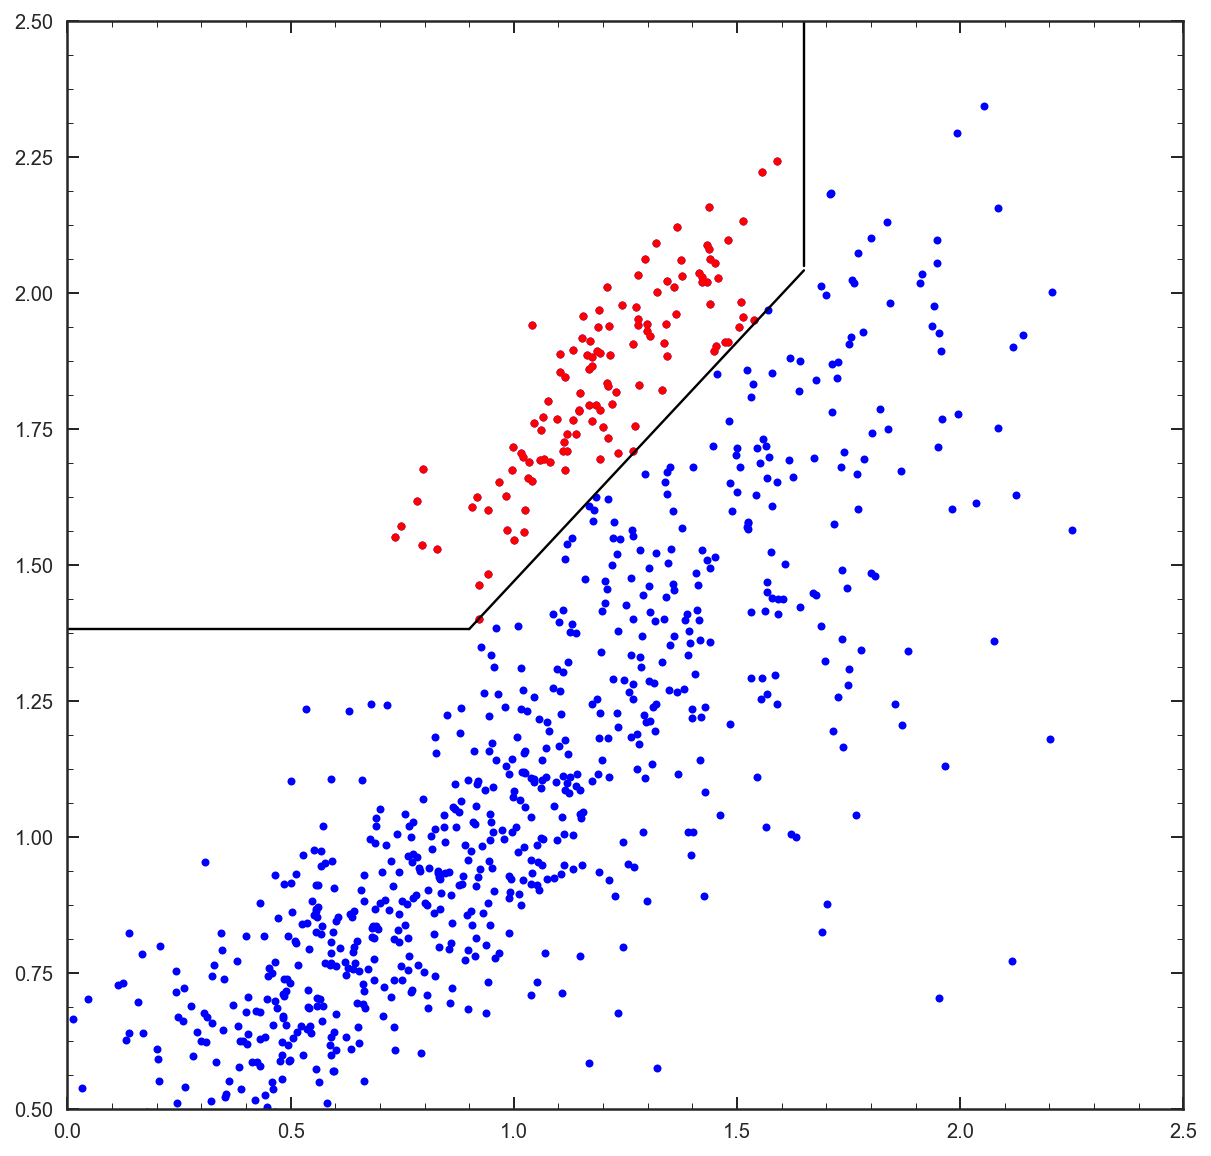

In [21]:
v4N_red = v4N.query('mass > 10**9.8 and 0.8 < z500 < 2.5 and use == 1 and star < 0.8 and g102 == True')
v4S_red = v4S.query('mass > 10**9.8 and 0.8 < z500 < 2.5 and use == 1 and star < 0.8 and g102 == True')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_red.restU, v4N_red.restV)
NVJ = Color(v4N_red.restV, v4N_red.restJ)

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
NQ = []
Ssf = []
Nsf = []
for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
    else:
        Nsf.append(i)
    
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)
        
plt.figure(figsize=[10,10])
plt.plot(SVJ, SUV,'bo',ms=4)
plt.plot(NVJ, NUV,'bo',ms=4)

plt.plot(SVJ[SQ], SUV[SQ],'ro',ms=4)
plt.plot(NVJ[NQ], NUV[NQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [22]:
(len(Ssf)+len(Nsf)) / 10 *12

898.8000000000001

[0, 2.5, 0.5, 2.5]

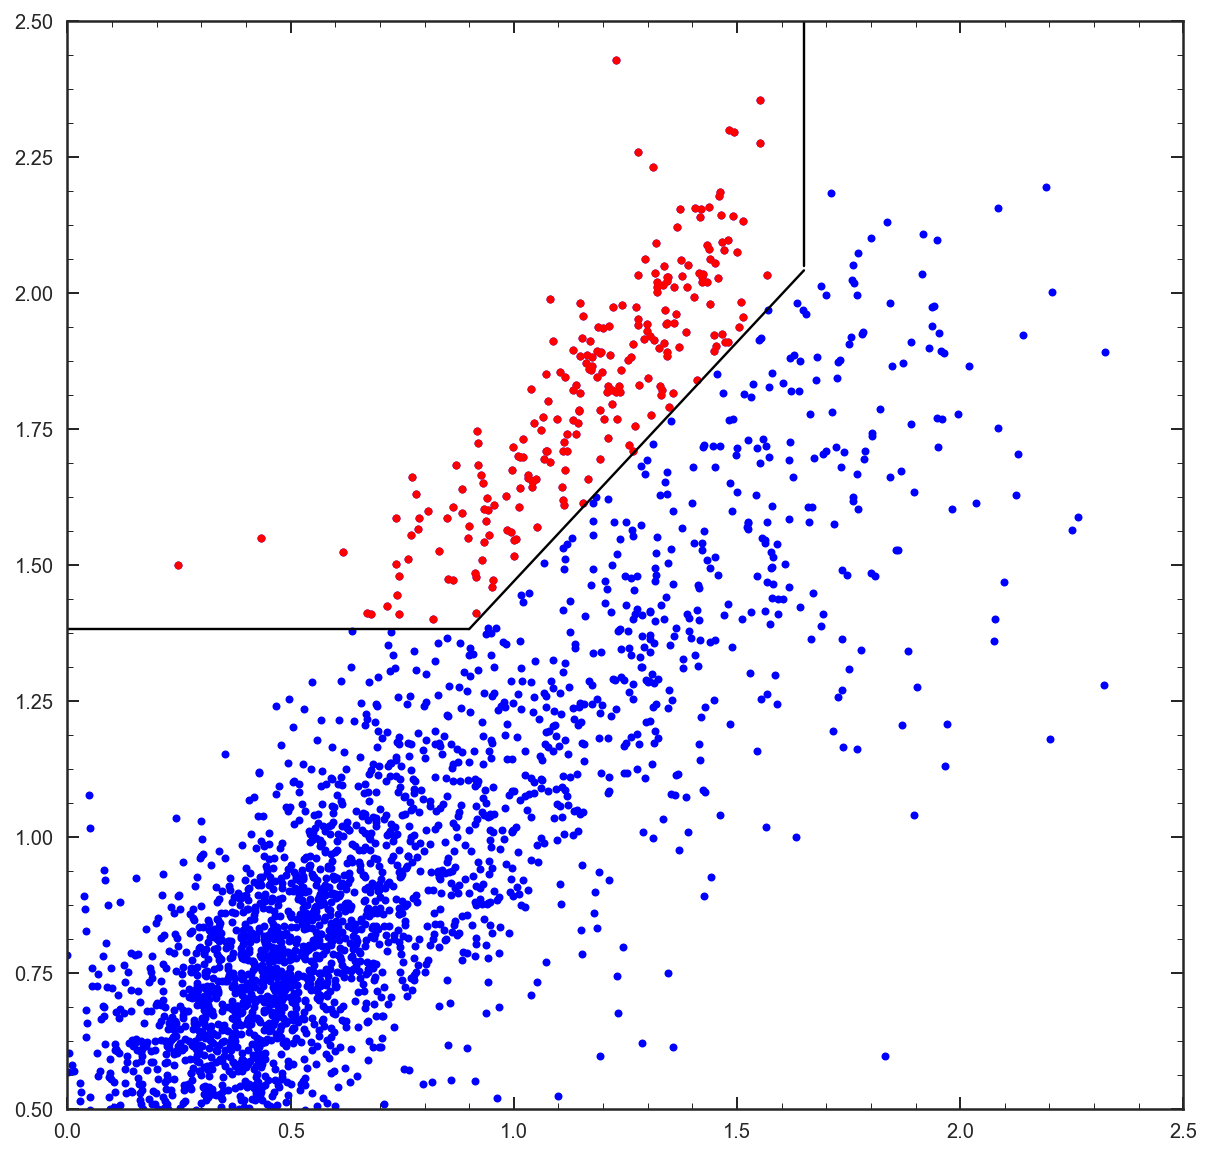

In [19]:
v4N_red = v4N.query('0.25 < z500 < 1.5 and use == 1 and star < 0.8 and g102 == True')
v4S_red = v4S.query('0.25 < z500 < 1.5 and use == 1 and star < 0.8 and g102 == True')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_red.restU, v4N_red.restV)
NVJ = Color(v4N_red.restV, v4N_red.restJ)

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
NQ = []

Ssf = []
Nsf = []

for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
    else:
        Nsf.append(i)
        
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)

plt.figure(figsize=[10,10])
plt.plot(SVJ, SUV,'bo',ms=4)
plt.plot(NVJ, NUV,'bo',ms=4)

plt.plot(SVJ[SQ], SUV[SQ],'ro',ms=4)
plt.plot(NVJ[NQ], NUV[NQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [9]:
OII = 3730
Hb = 4863
OIII = 5008
Ha = 6564

In [5]:
z = 1.3
#lims 8000, 16500, redshift lims 1.14 < z < 1.54 for all, 1.14 < z < 2.3 for R23
print(OII * (1+z), OIII * (1+z), Ha * (1+z))

8579.0 11518.4 15097.199999999999


In [18]:
Ha * (1 + 0.25), Ha * (1 + 1.5)

(8205.0, 16410.0)

In [20]:
Nid = v4N_red.id[Nsf].values
Sid = v4S_red.id[Ssf].values

# Nlmass_zg = N_zg.lmass[N_VJ_zg[NSF_zg].index].values


NIDS = np.repeat('00000', len(Nid))
for i in range(len(Nid)):
    NIDS[i] = str(Nid[i])
    if len(NIDS[i]) < 5:
        NIDS[i] = '0' + NIDS[i]
        
SIDS = np.repeat('00000', len(Sid))
for i in range(len(Sid)):
    SIDS[i] = str(Sid[i])
    if len(SIDS[i]) < 5:
        SIDS[i] = '0' + SIDS[i]

In [52]:
glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.full.fits'.format(NIDS[0]))[0]

'/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GN2/j123652p6215/Prep/GN2_08076.full.fits'

In [21]:
N_rshift = np.zeros(len(NIDS))
N_rshift16 = np.zeros(len(NIDS))
N_rshift84 = np.zeros(len(NIDS))

N_OII_f = np.zeros(len(NIDS))
N_OIII_f = np.zeros(len(NIDS))
N_Hb_f= np.zeros(len(NIDS))
N_Ha_f= np.zeros(len(NIDS))


for i in range(len(NIDS)):
    try:
        file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.full.fits'.format(NIDS[i]))[0]
    except:
        print(NIDS[i])
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    N_rshift[i] = dat[1].header['Z50']
    N_rshift16[i] = dat[1].header['Z16']
    N_rshift84[i] = dat[1].header['Z84']
    
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            N_OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            N_OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            N_Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            N_Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
            
S_rshift = np.zeros(len(SIDS))
S_rshift16 = np.zeros(len(SIDS))
S_rshift84 = np.zeros(len(SIDS))

S_OII_f = np.zeros(len(SIDS))
S_OIII_f = np.zeros(len(SIDS))
S_Hb_f= np.zeros(len(SIDS))
S_Ha_f= np.zeros(len(SIDS))


for i in range(len(SIDS)):
    try:
        file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*{0}.full.fits'.format(SIDS[i]))[0]
    except:
        print(NIDS[i])    
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    S_rshift[i] = dat[1].header['Z50']
    S_rshift16[i] = dat[1].header['Z16']
    S_rshift84[i] = dat[1].header['Z84']
    
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            S_OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            S_OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            S_Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            S_Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]

09569
11327
16752
18448


(array([946., 128.,  59.,  30.,  24.,   5.,   7.,  10.,   3.,   6.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([3.52785206e-04, 7.87717760e-02, 1.57190767e-01, 2.35609758e-01,
        3.14028749e-01, 3.92447739e-01, 4.70866730e-01, 5.49285721e-01,
        6.27704712e-01, 7.06123703e-01, 7.84542694e-01, 8.62961684e-01,
        9.41380675e-01, 1.01979967e+00, 1.09821866e+00, 1.17663765e+00,
        1.25505664e+00, 1.33347563e+00, 1.41189462e+00, 1.49031361e+00,
        1.56873260e+00, 1.64715159e+00, 1.72557058e+00, 1.80398957e+00,
        1.88240857e+00, 1.96082756e+00, 2.03924655e+00, 2.11766554e+00,
        2.19608453e+00, 2.27450352e+00, 2.35292251e+00]),
 <a list of 30 Patch objects>)

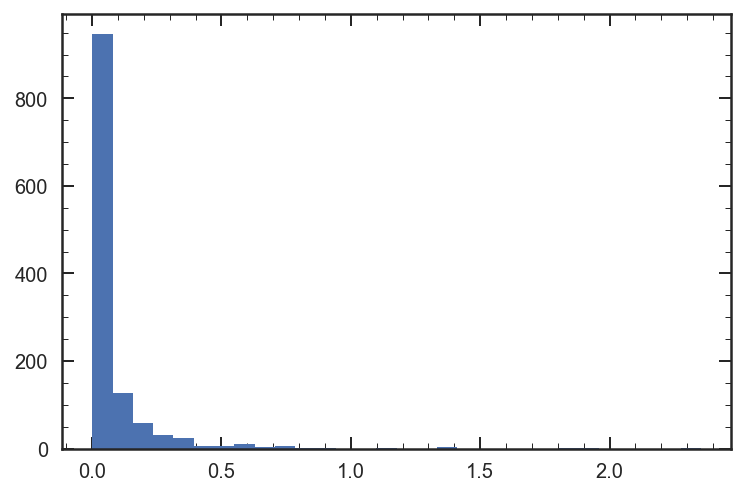

In [50]:
plt.hist(rshift84 - rshift16,bins = 30)

In [189]:
O32 = []
Omasses = []
OIDS = []
Oz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and rshift84[i] - rshift16[i] < 0.01 and rshift[i] > 1.0:
        O32.append((OIII_f[i] / OII_f[i]))
        Omasses.append(Nlmass_zg[i])
        OIDS.append(NIDS[i])
        Oz.append(rshift[i])

Text(0,0.5,'log(O32)')

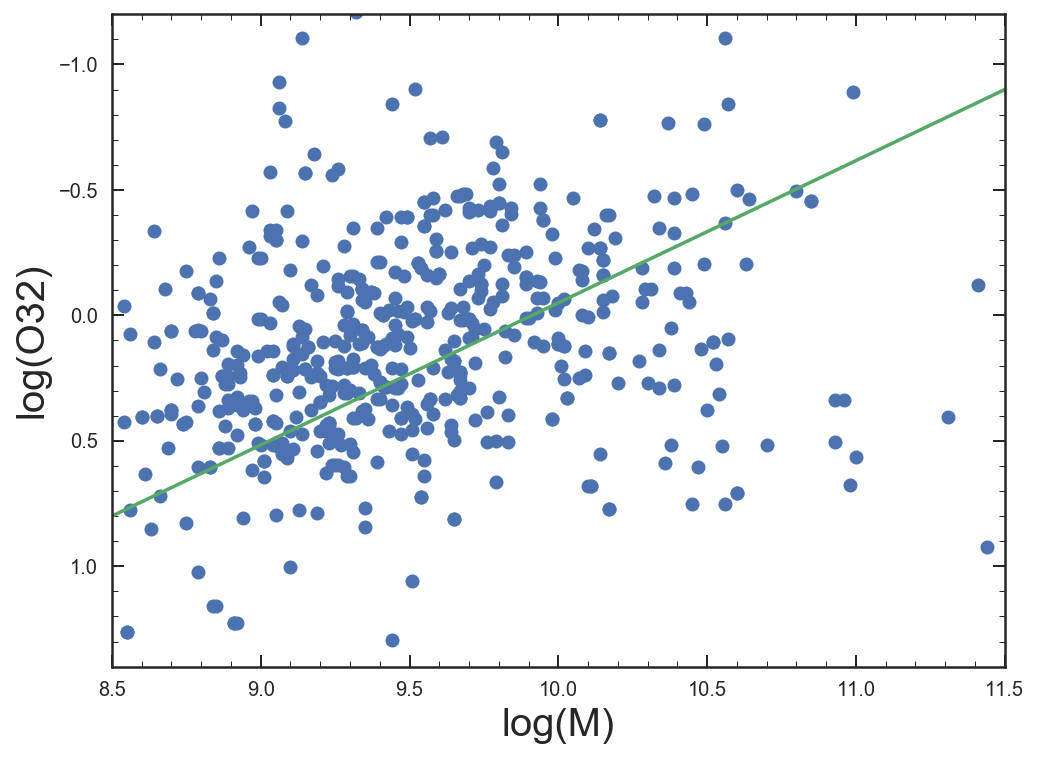

In [188]:
plt.figure(figsize=[8,6])
plt.plot(Omasses,np.log10(O32),'o')
plt.plot([8.5,11.5],[.8,-.9])
plt.ylim(1.4,-1.2)
plt.xlim(8.5,11.5)
plt.xlabel('log(M)', fontsize=20)
plt.ylabel('log(O32)', fontsize=20)

In [171]:
R23 = []
Rmasses = []
RIDS = []
Rz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and Hb_f[i] > 0 and rshift84[i] - rshift16[i] < 0.01 and rshift[i] > 1.3:
        R23.append((OIII_f[i] + OII_f[i]) / Hb_f[i])
        Rmasses.append(Nlmass_zg[i])
        RIDS.append(NIDS[i])
        Rz.append(rshift[i])

Text(0,0.5,'log(R32)')

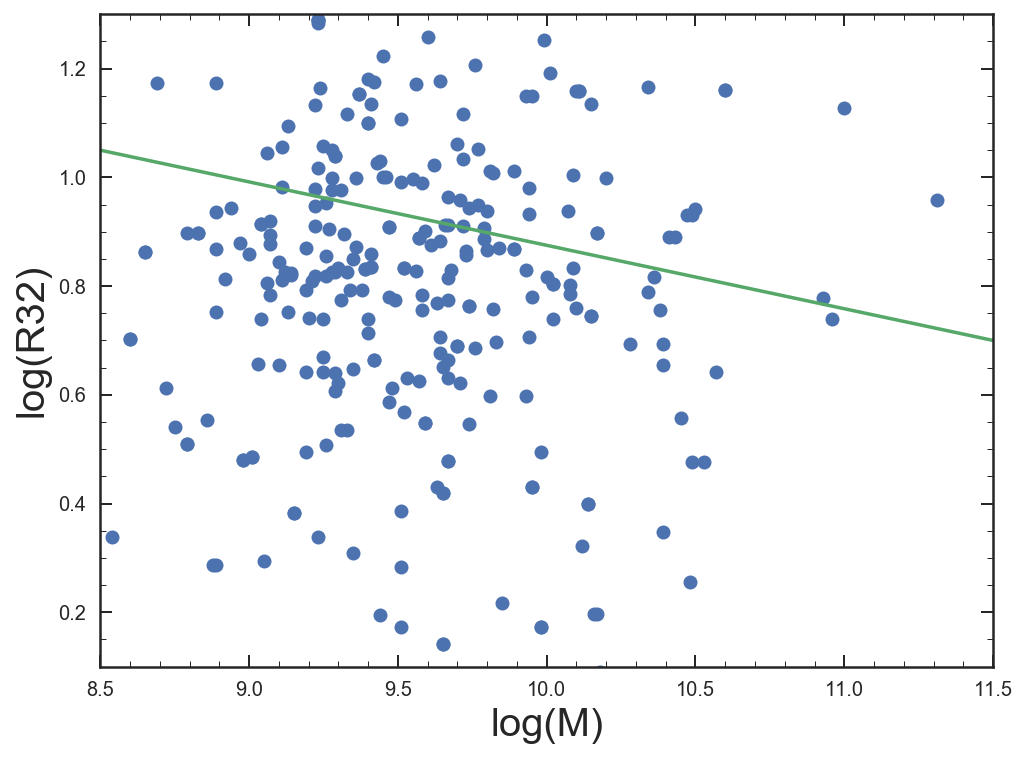

In [163]:
plt.figure(figsize=[8,6])
plt.plot(Rmasses,np.log10(R23),'o')
plt.plot([8.5,11.5],[1.05,0.7])
plt.ylim(0.1, 1.3)
plt.xlim(8.5,11.5)
plt.xlabel('log(M)', fontsize=20)
plt.ylabel('log(R32)', fontsize=20)

In [75]:
R23 = []
Rmasses = []
RIDS = []
Rz = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and Hb_f[i] > 0 and rshift84[i] - rshift16[i] < 0.003 and rshift[i] > 1.3:
        R23.append((OIII_f[i] + OII_f[i]) / Hb_f[i])
        Rmasses.append(Nlmass_zg[i])
        RIDS.append(NIDS[i])
        Rz.append(rshift[i])

In [27]:
def Stack(wv, fl , er):
    flgrid = np.transpose(fl)
    errgrid = np.transpose(er)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

def Stack_g102_g141(rfwv, Bwv, Bfl, Ber, Rwv, Rfl, Rer, z):
    flgrid = np.zeros([2,len(rfwv)])
    ergrid = np.zeros([2,len(rfwv)])
    
    flgrid[0] = interp1d(Bwv / (1+z), Bfl,fill_value=0,bounds_error=False)(rfwv)
    flgrid[1] = interp1d(Rwv / (1+z), Rfl,fill_value=0,bounds_error=False)(rfwv)
    
    ergrid[0] = interp1d(Bwv / (1+z), Ber,fill_value=0,bounds_error=False)(rfwv)
    ergrid[1] = interp1d(Rwv / (1+z), Rer,fill_value=0,bounds_error=False)(rfwv)
    
    weigrid = ergrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2,len(rfwv)])
    for i in range(len(rfwv)):
        stack[i] = np.sum(flgrid.T[i] * weigrid.T[i]) / (np.sum(weigrid.T[i]))   
        err[i] = 1 / np.sqrt(np.sum(weigrid.T[i]))
    ################
    
    err[~(stack**2 > 0)] = 10
    stack[~(stack**2 > 0)] = 0
    
    return stack, err

In [216]:
rfwv = np.arange(2400,7000,12)
flxgrid = np.zeros([len(OIDS),len(rfwv)])
errgrid = np.zeros([len(OIDS),len(rfwv)])

IDX = [U for U in range(len(rfwv)) if 4000 < rfwv[U] < 6000]

for i in range(len(OIDS)):

    Bwv, Bfl, Ber = np.zeros([3,2])

    Rwv, Rfl, Rer = np.zeros([3,2])

    file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.1D.fits'.format(OIDS[i]))[0]
    dat = fits.open(file)

    try:
        Bwv = np.array(dat['G102'].data['wave']).T
        Bfl = np.array(dat['G102'].data['flux'] / dat['G102'].data['flat']).T
        Ber = np.array(dat['G102'].data['err'] / dat['G102'].data['flat']).T
        
        
        Bwv = Bwv[Bfl**2 > 0]
        Ber = Ber[Bfl**2 > 0]
        Bfl = Bfl[Bfl**2 > 0]

    except:
        print('no g102')

    try:
        Rwv = np.array(dat['G141'].data['wave']).T
        Rfl = np.array(dat['G141'].data['flux'] / dat['G141'].data['flat']).T
        Rer = np.array(dat['G141'].data['err'] / dat['G141'].data['flat']).T

        Rwv = Rwv[Rfl**2 > 0]
        Rer = Rer[Rfl**2 > 0]
        Rfl = Rfl[Rfl**2 > 0]

    except:
        print('no g141')

    st,er = Stack_g102_g141(rfwv, Bwv, Bfl, Ber, Rwv, Rfl, Rer, Oz[i])
    
#     errgrid[i] = er / np.trapz(st[IDX],rfwv[IDX])
#     flxgrid[i] = st / np.trapz(st[IDX],rfwv[IDX])
    
    errgrid[i] = er
    flxgrid[i] = st

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launche

no g102
no g141
no g141
no g141
no g141
no g141
no g141
no g102
no g102
no g141
no g141
no g141
no g141
no g102
no g102
no g141
no g141
no g141
no g141
no g102
no g102


In [217]:
stack,error = Stack(rfwv,flxgrid,errgrid)

plt.figure(figsize=[20,5])
plt.errorbar(rfwv, stack,error)
plt.xlim(2600,7000)
plt.ylim(0.00035,0.0011)

(1e-19, 6.1e-19)

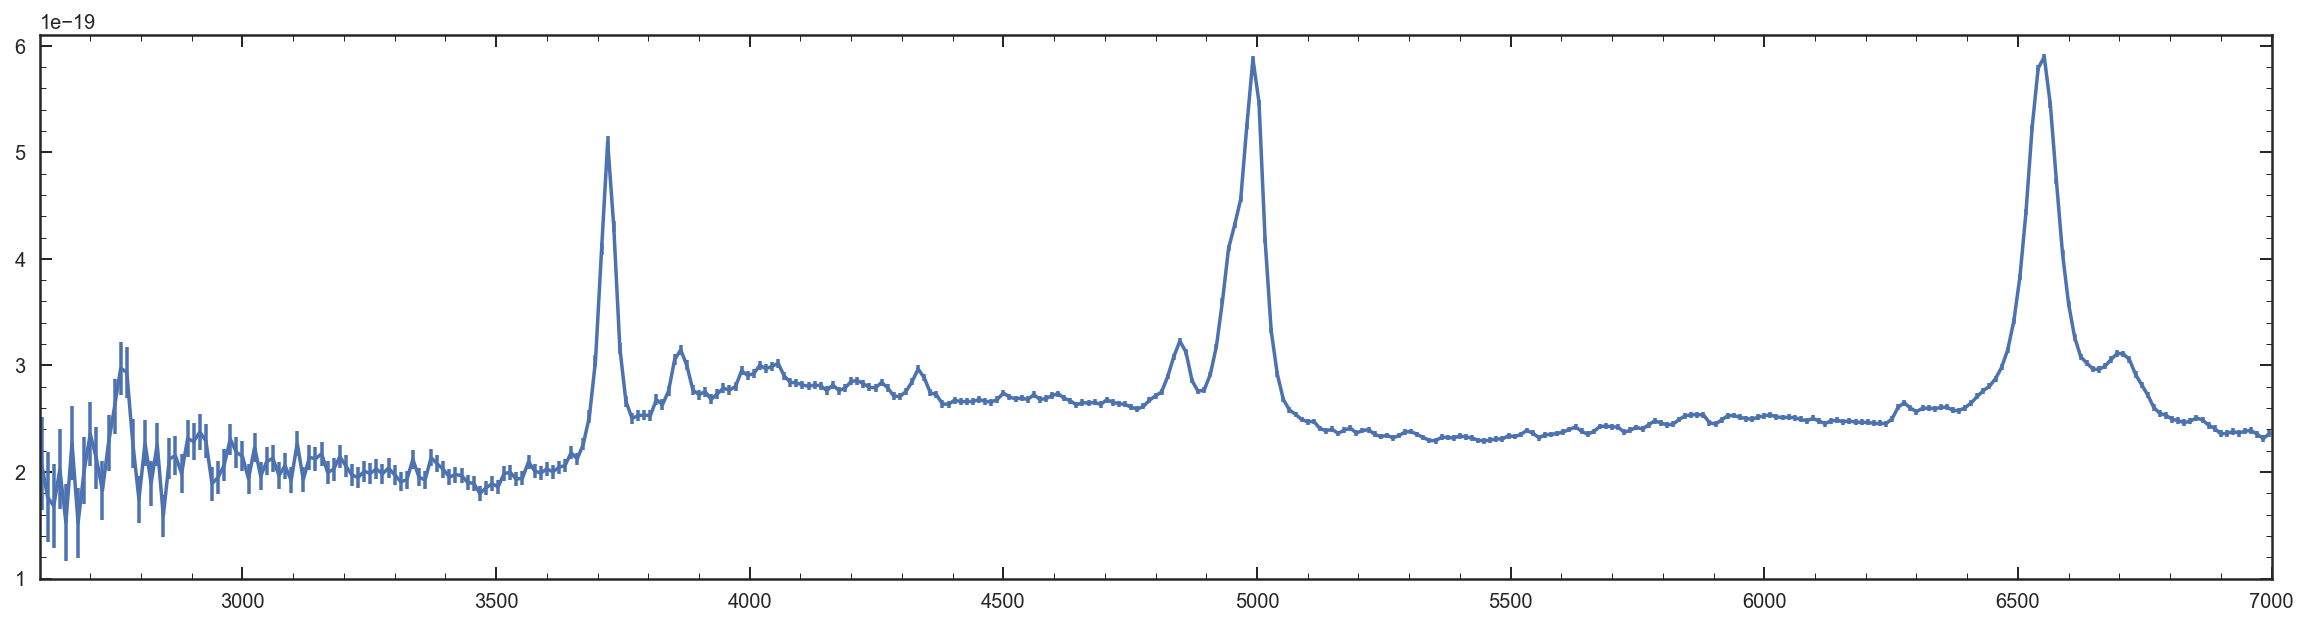

In [221]:
plt.figure(figsize=[20,5])
plt.errorbar(rfwv, stack,error)
plt.xlim(2600,7000)
plt.ylim(1E-19,6.1E-19)

In [13]:
len(Ha_f), len(NIDS)

(1229, 1229)

In [16]:
np.mean(Ha_f)

3.20015831765176e-07

In [22]:
NIDS[N_Ha_f > 5E-16], N_rshift[N_Ha_f > 5E-16], SIDS[S_Ha_f > 5E-16], S_rshift[S_Ha_f > 5E-16]

(array(['09594', '10512', '10752', '11124', '12098', '12343', '12979',
        '13618', '13636', '13776', '13777', '14184', '14302', '14330',
        '14372', '14533', '14585', '16041', '17477', '17596', '17784',
        '17930', '17986', '18043', '18197', '18224', '19257', '20051',
        '20228', '20904', '21285', '21593', '22285', '22874', '22945',
        '24582', '24780', '26193', '26823', '27532', '28005', '28744',
        '28909', '30204', '30588', '31621', '31867', '32157', '32427',
        '33231', '33724', '34397', '34739', '35470', '35822', '37533',
        '37615', '37683'], dtype='<U5'),
 array([0.25191202, 1.26809246, 0.93797728, 0.45964038, 0.45762384,
        0.77900963, 0.39903269, 0.4729361 , 0.46002991, 0.46275032,
        1.23170269, 0.84603103, 0.47357516, 0.24939988, 0.55864844,
        0.70007569, 0.64279013, 0.78110301, 1.04637303, 0.48673416,
        0.53423794, 0.65708731, 0.56034257, 1.36423603, 1.35835114,
        0.95935474, 0.73981376, 0.75420593, 0.68045

In [23]:
from shutil import copy

In [31]:
for i in range(len(NIDS[N_Ha_f > 5E-16])):
    flist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}*1D*'.format(NIDS[N_Ha_f > 5E-16][i]))
    for ii in range(len(flist)):
        copy(flist[ii], '/Volumes/Vince_CLEAR/H_alpha/GND/{0}'.format(os.path.basename(flist[ii])))

In [32]:
for i in range(len(SIDS[S_Ha_f > 5E-16])):
    flist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*{0}*1D*'.format(SIDS[S_Ha_f > 5E-16][i]))
    for ii in range(len(flist)):
        copy(flist[ii], '/Volumes/Vince_CLEAR/H_alpha/GSD/{0}'.format(os.path.basename(flist[ii])))

# proposal stuff

In [33]:
np.log10(10**10 *0.7)

9.845098040014257

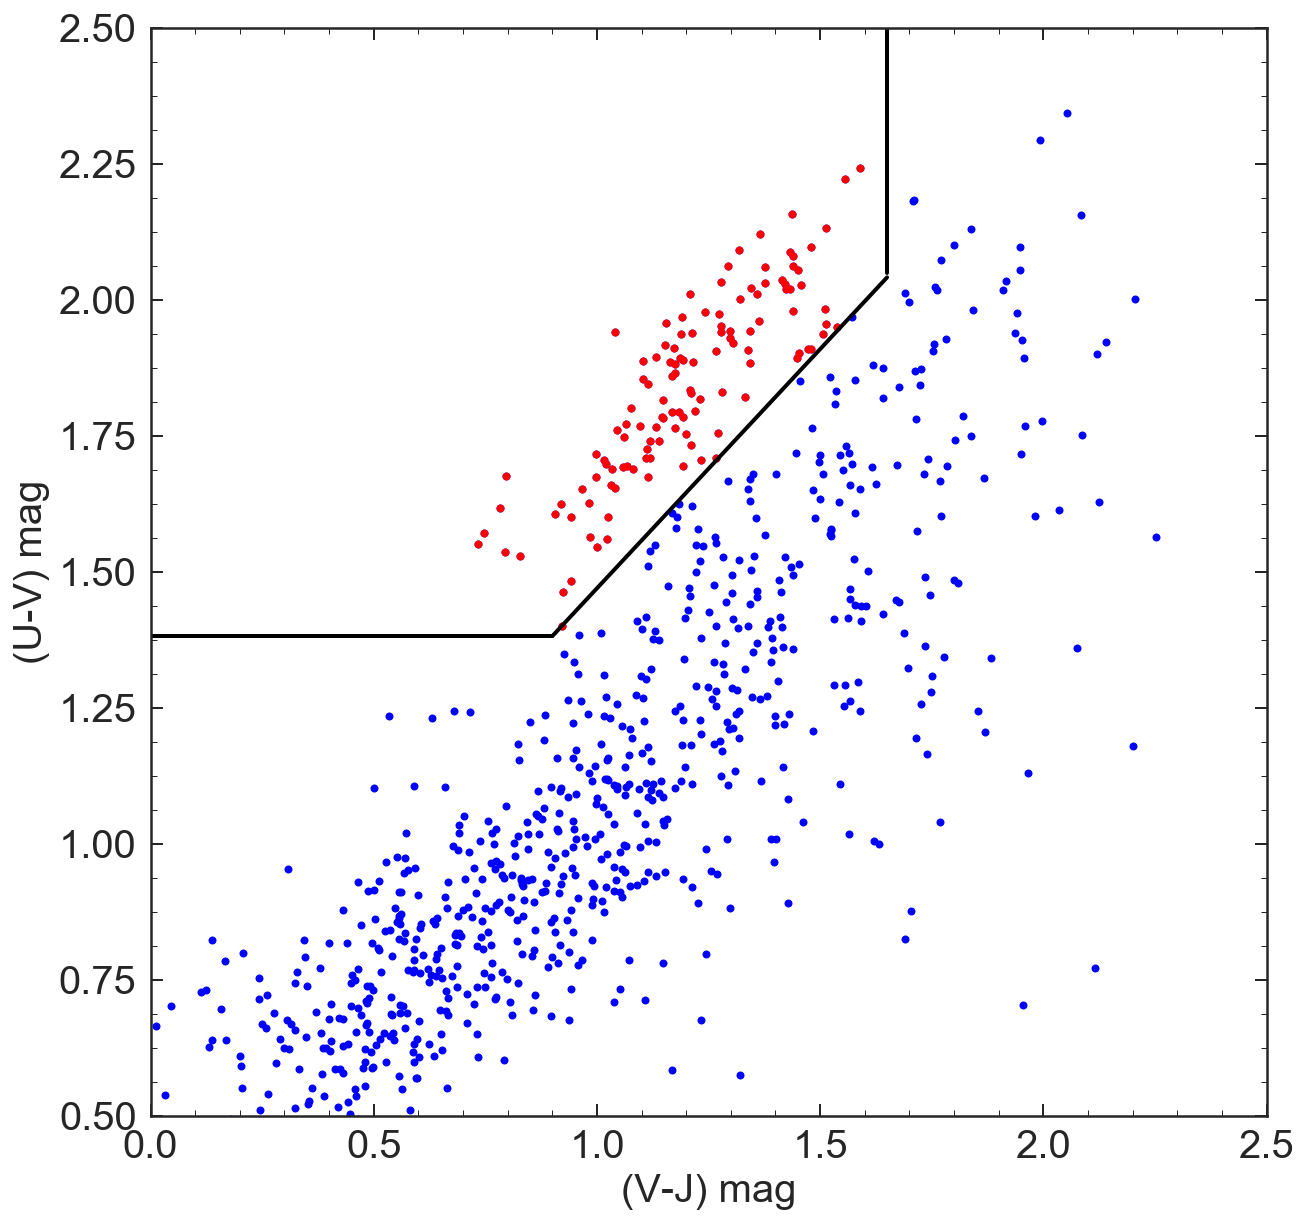

In [151]:
v4N_red = v4N.query('10**9.8 < mass and 0.8 < z500 < 2.5 and use == 1 and star < 0.8 and g102 == True')
v4S_red = v4S.query('10**9.8 < mass and 0.8 < z500 < 2.5 and use == 1 and star < 0.8 and g102 == True')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_red.restU, v4N_red.restV)
NVJ = Color(v4N_red.restV, v4N_red.restJ)

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
Ssf = []
NQ = []
Nsf = []

for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
#     if NUV[i] >1 and i not in NQ:
    else:
        Nsf.append(i)
        
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
#     if SUV[i] >1 and i not in SQ:
    else:
        Ssf.append(i)
        
plt.figure(figsize=[10,10])
plt.plot(SVJ, SUV,'bo',ms=4)
plt.plot(NVJ, NUV,'bo',ms=4)

# plt.plot(SVJ[Ssf], SUV[Ssf],'go',ms=4)
# plt.plot(NVJ[Nsf], NUV[Nsf],'go',ms=4)

plt.plot(SVJ[SQ], SUV[SQ],'ro',ms=4)
plt.plot(NVJ[NQ], NUV[NQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/proposal_uvj.png' ,bbox_inches = 'tight')


In [163]:
(len(Nsf) + len(Ssf)) /10 *12

898.8000000000001

In [24]:
Nid = v4N_red.id[Nsf].values
Sid = v4S_red.id[Ssf].values

NIDS = np.repeat('00000', len(Nid))
for i in range(len(Nid)):
    NIDS[i] = str(Nid[i])
    if len(NIDS[i]) < 5:
        NIDS[i] = '0' + NIDS[i]
        
SIDS = np.repeat('00000', len(Sid))
for i in range(len(Sid)):
    SIDS[i] = str(Sid[i])
    if len(SIDS[i]) < 5:
        SIDS[i] = '0' + SIDS[i]

In [25]:
N_rshift = np.zeros(len(NIDS))
N_rshift16 = np.zeros(len(NIDS))
N_rshift84 = np.zeros(len(NIDS))

N_OII_f = np.zeros(len(NIDS))
N_OIII_f = np.zeros(len(NIDS))
N_Hb_f= np.zeros(len(NIDS))
N_Ha_f= np.zeros(len(NIDS))


for i in range(len(NIDS)):
    try:
        file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.full.fits'.format(NIDS[i]))[0]
    except:
        print(NIDS[i])
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    N_rshift[i] = dat[1].header['Z50']
    N_rshift16[i] = dat[1].header['Z16']
    N_rshift84[i] = dat[1].header['Z84']
    
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            N_OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            N_OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            N_Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            N_Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
            
S_rshift = np.zeros(len(SIDS))
S_rshift16 = np.zeros(len(SIDS))
S_rshift84 = np.zeros(len(SIDS))

S_OII_f = np.zeros(len(SIDS))
S_OIII_f = np.zeros(len(SIDS))
S_Hb_f= np.zeros(len(SIDS))
S_Ha_f= np.zeros(len(SIDS))


for i in range(len(SIDS)):
    try:
        file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*{0}.full.fits'.format(SIDS[i]))[0]
    except:
        print(NIDS[i])    
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    S_rshift[i] = dat[1].header['Z50']
    S_rshift16[i] = dat[1].header['Z16']
    S_rshift84[i] = dat[1].header['Z84']
    
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            S_OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            S_OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            S_Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            S_Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]

11327
16717
16752
20325


In [139]:
from IPython.display import Image, display
import matplotlib.image as mpimg

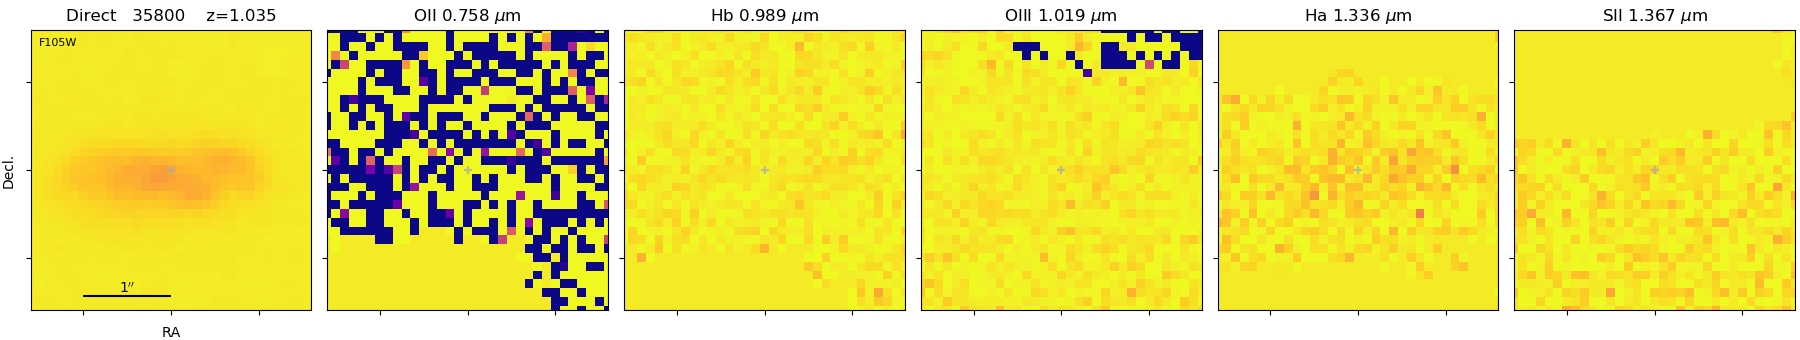

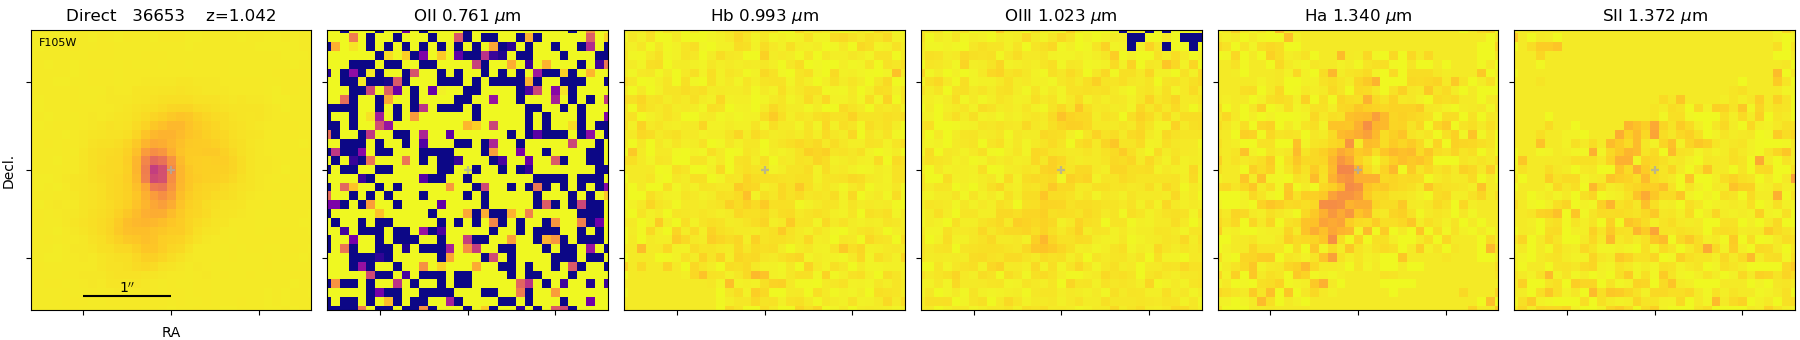

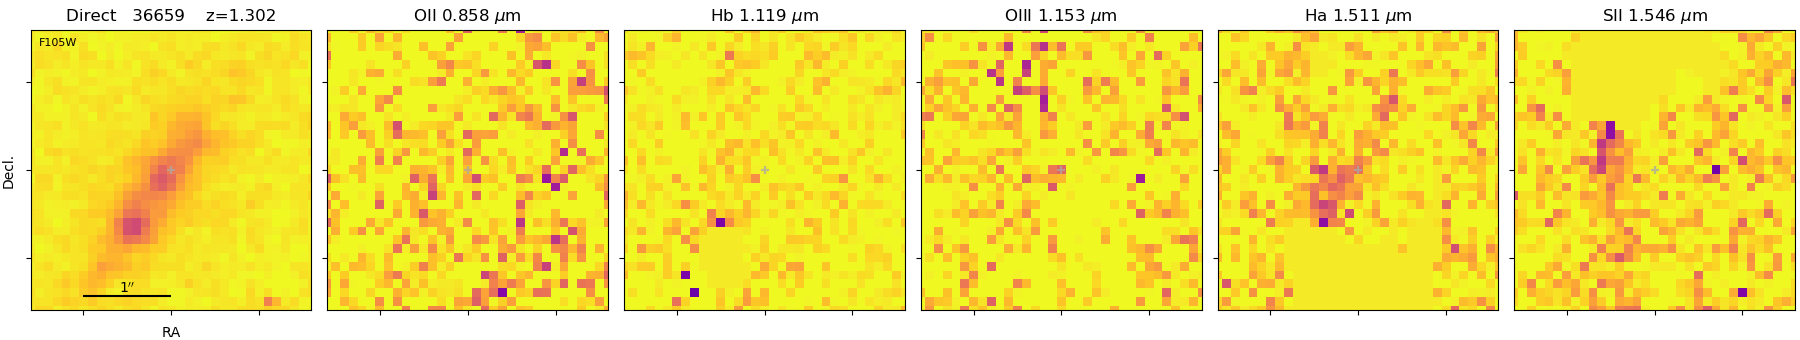

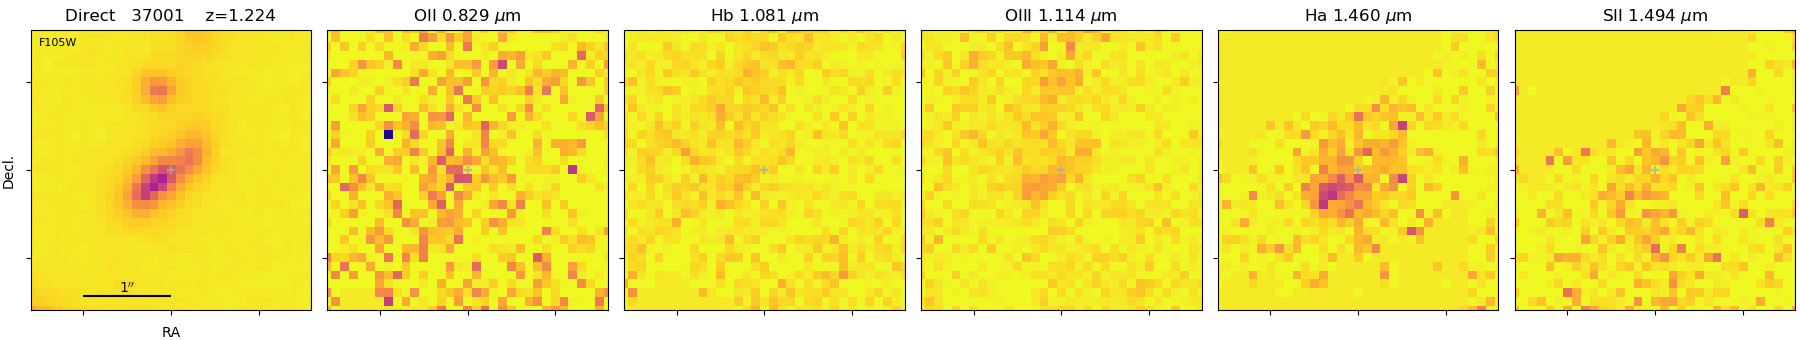

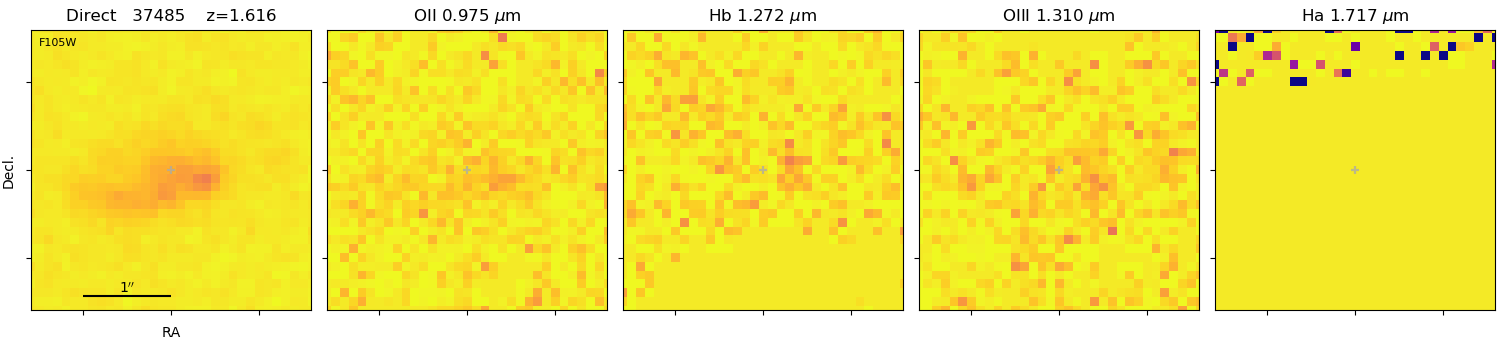

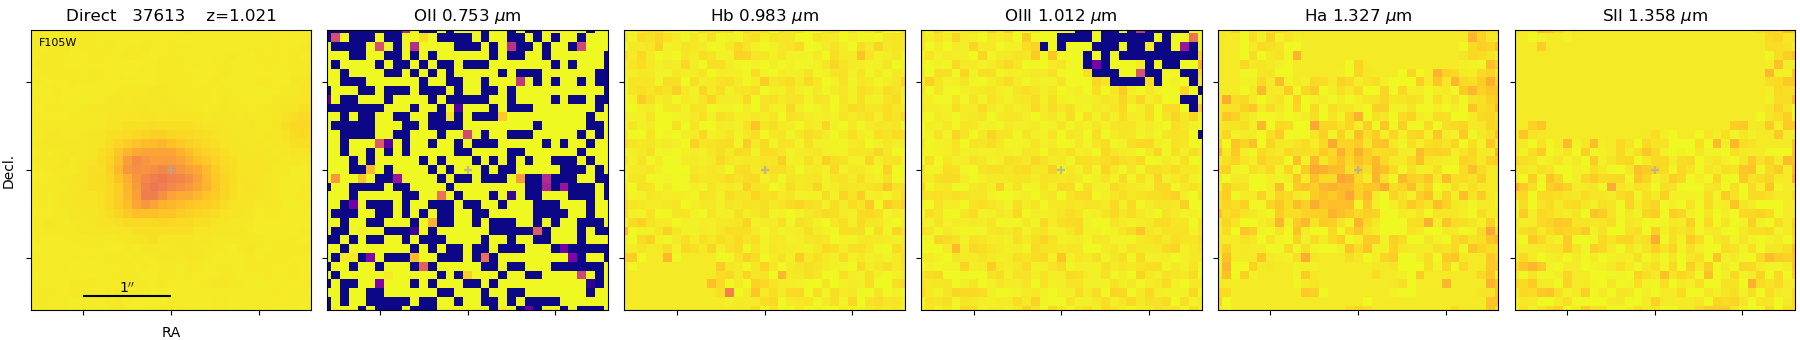

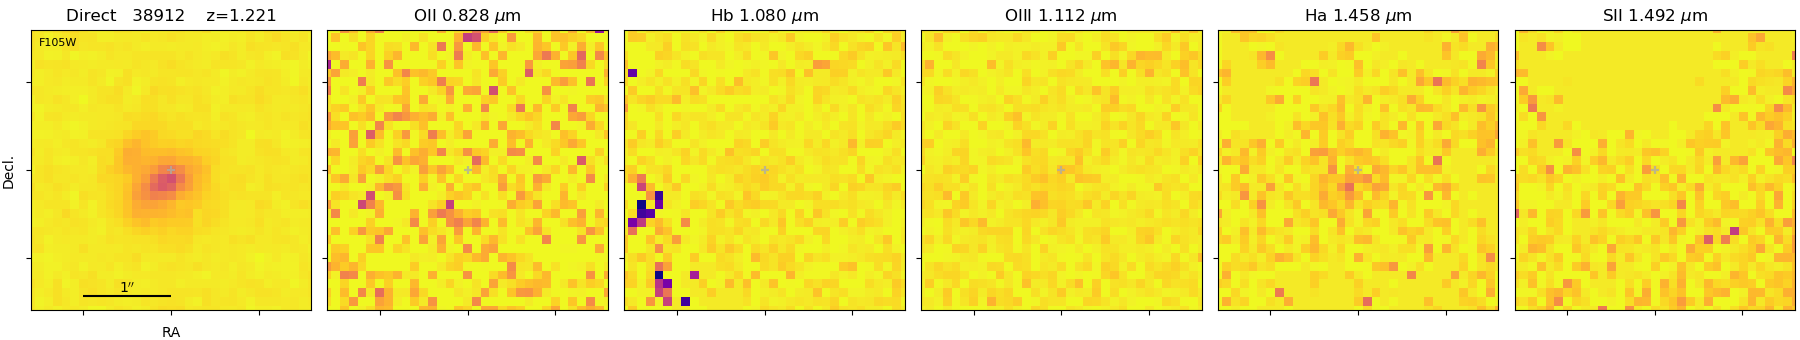

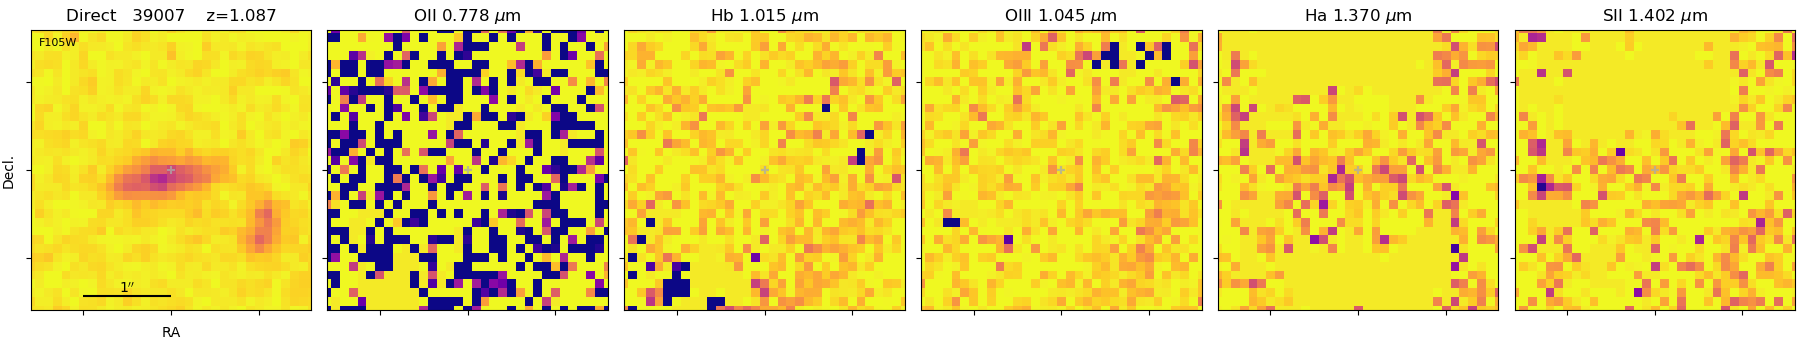

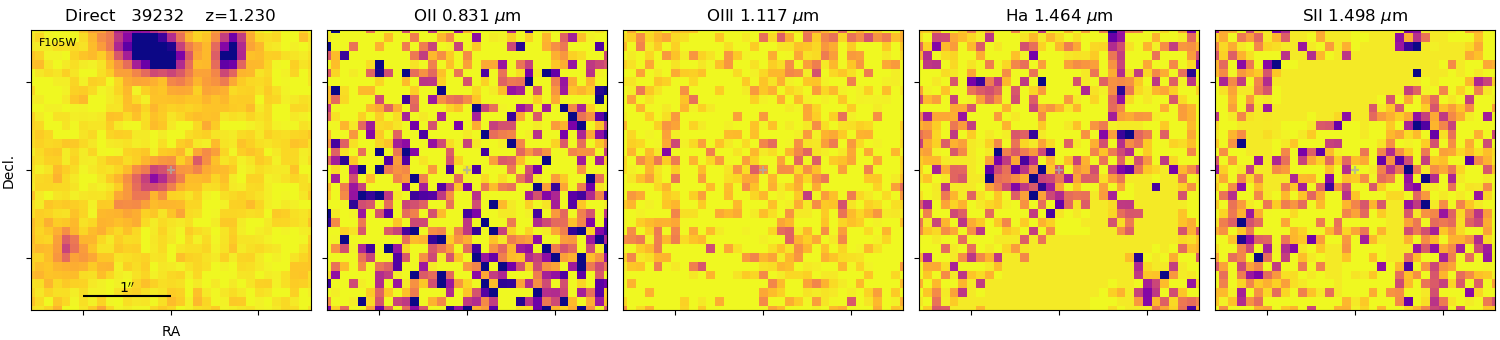

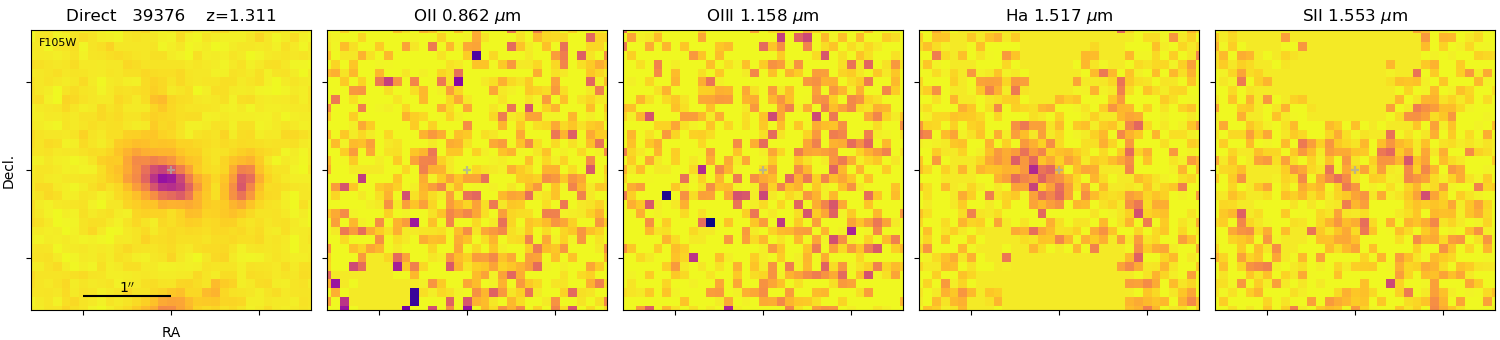

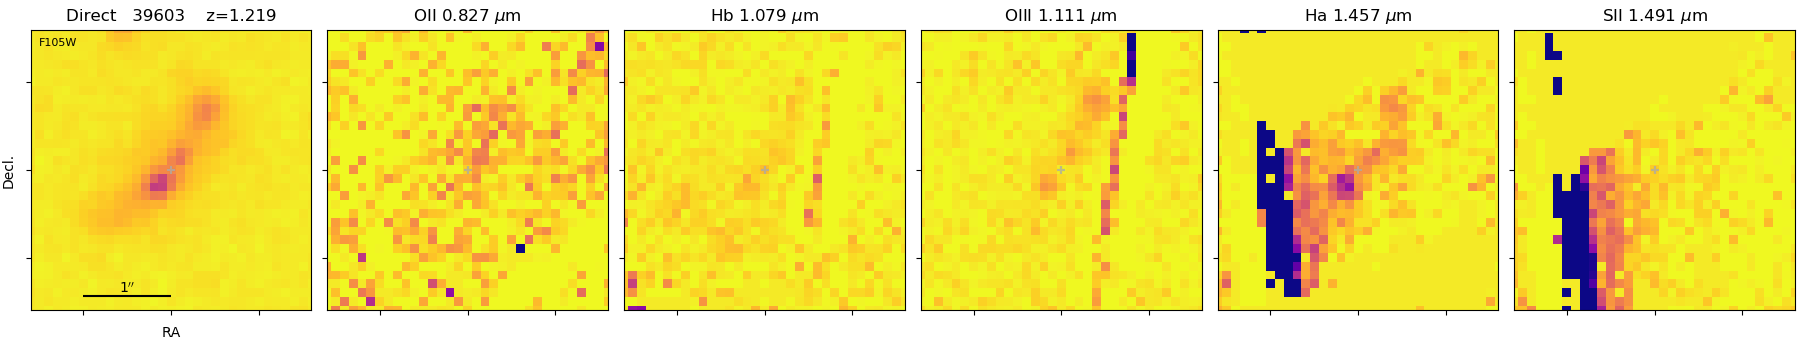

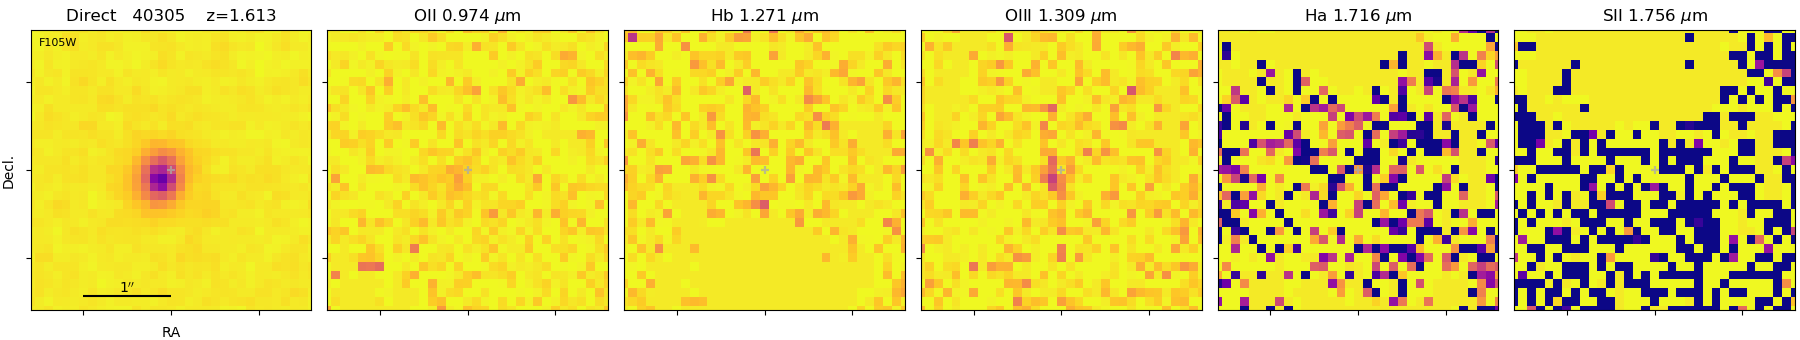

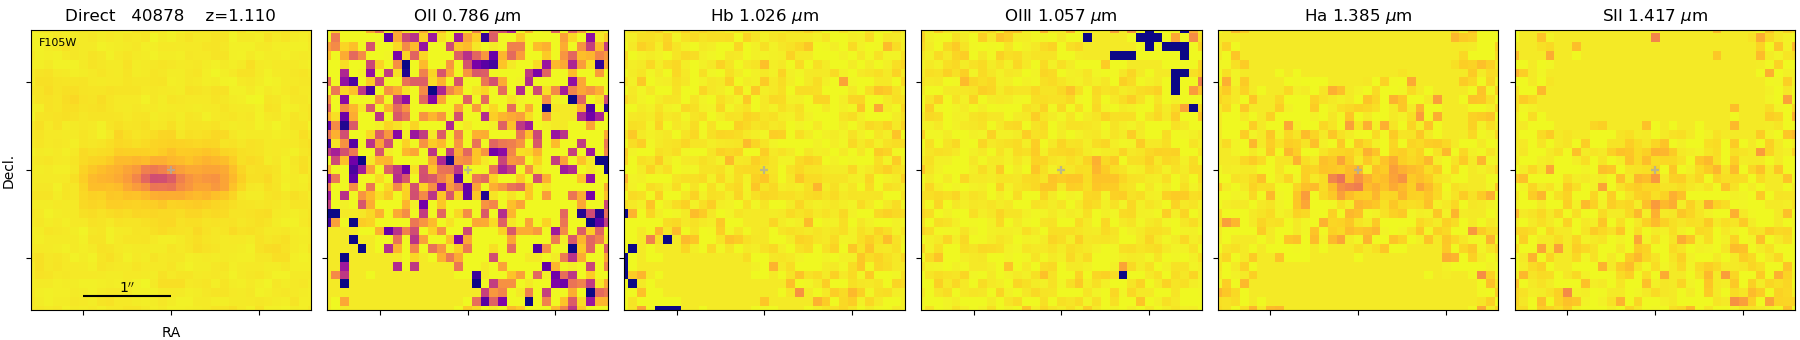

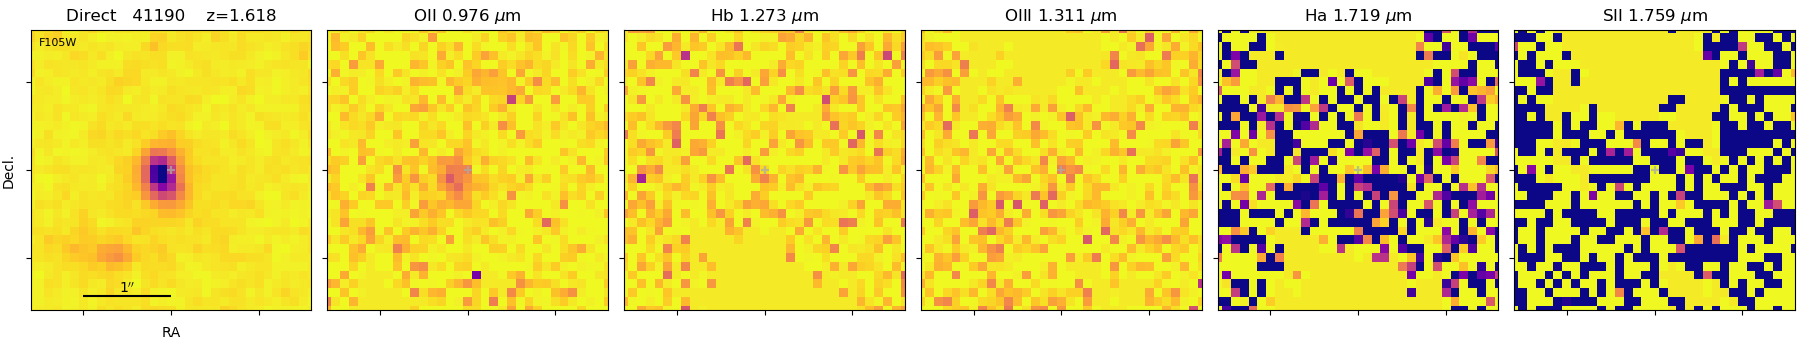

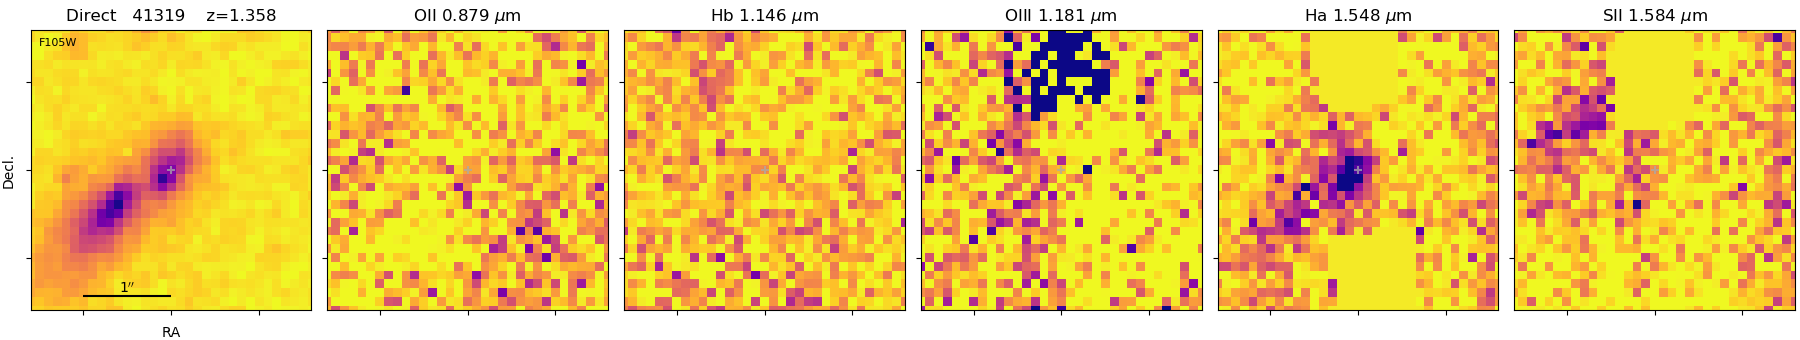

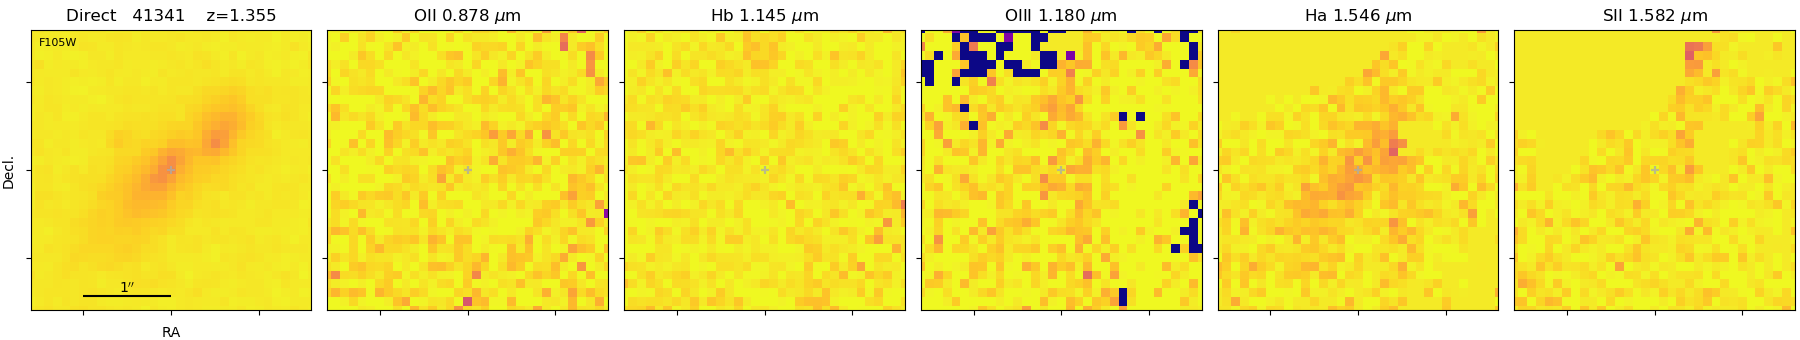

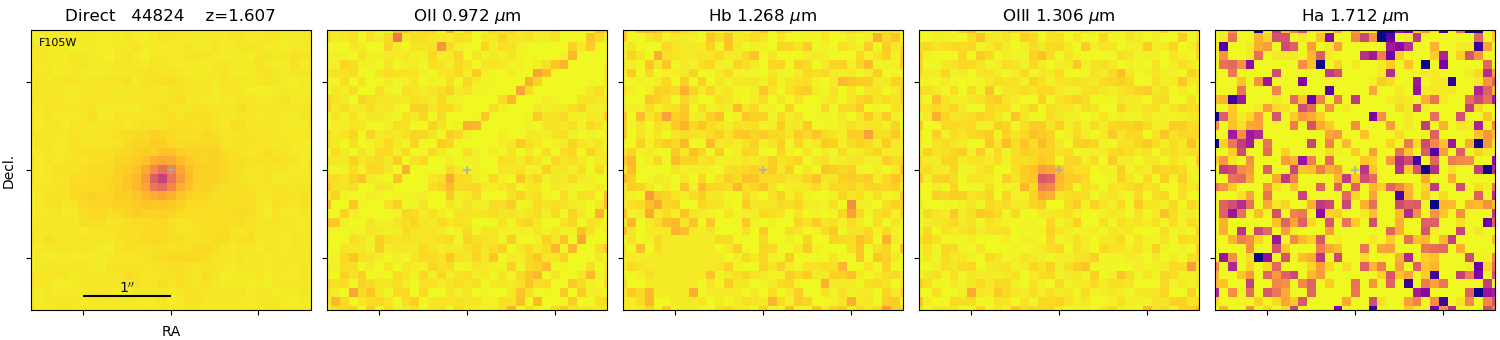

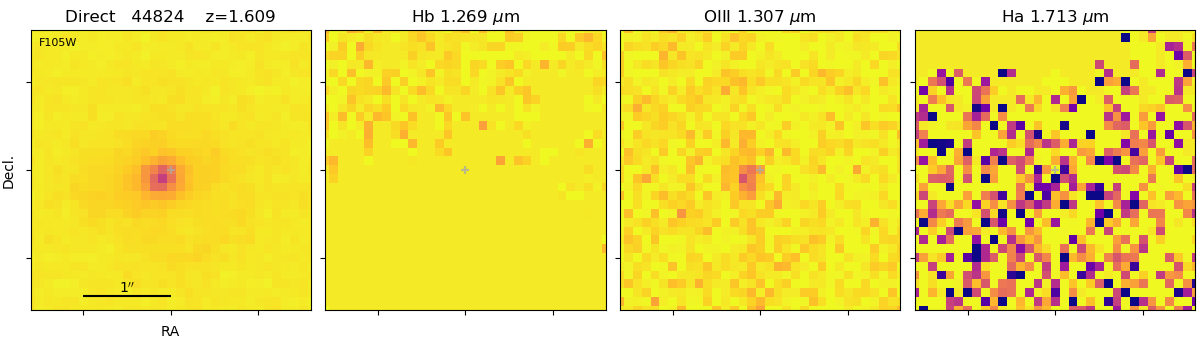

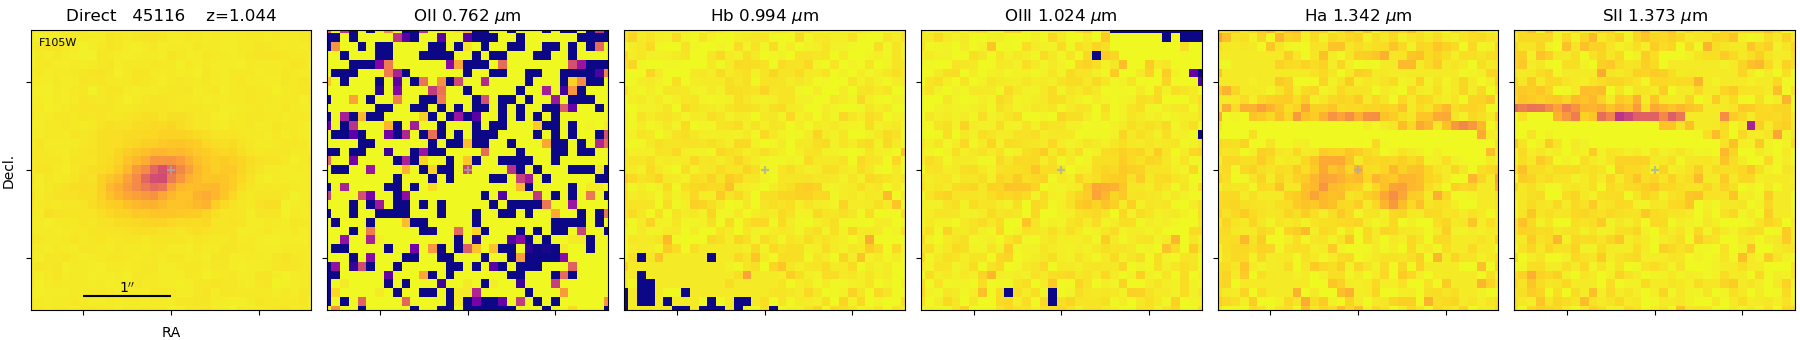

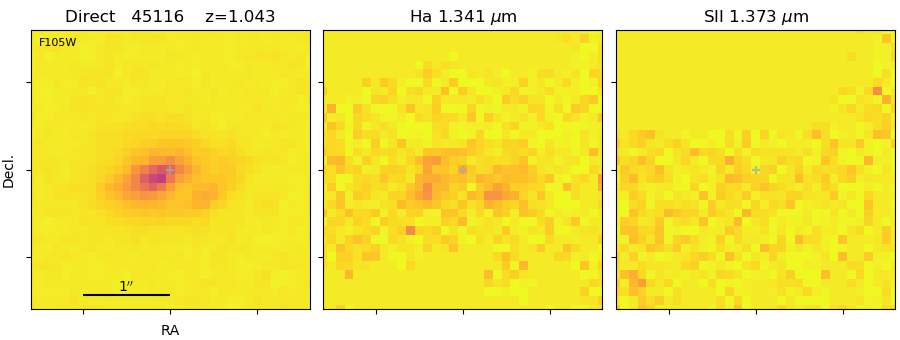

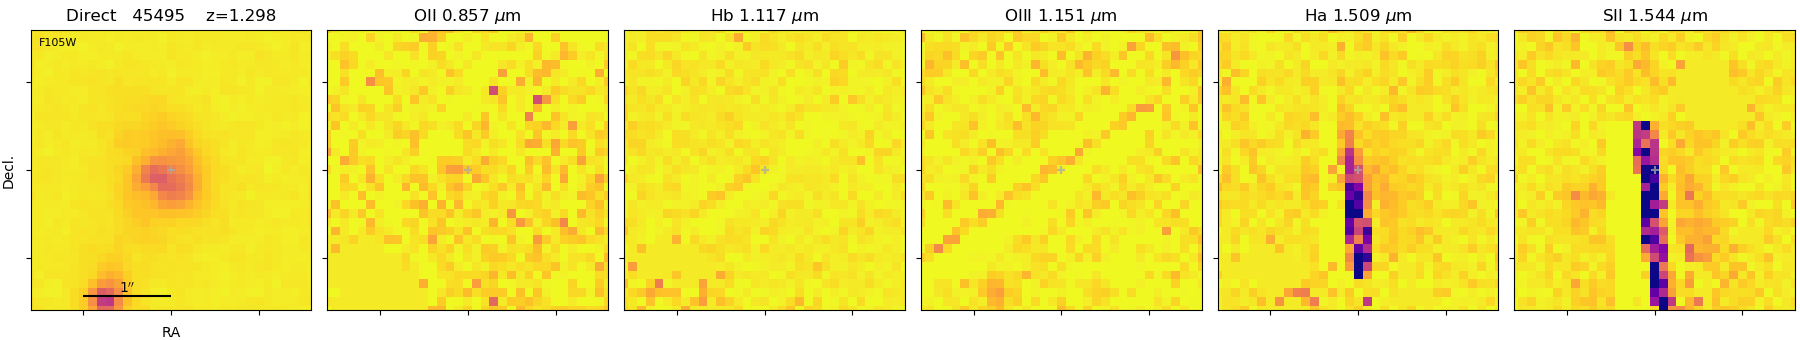

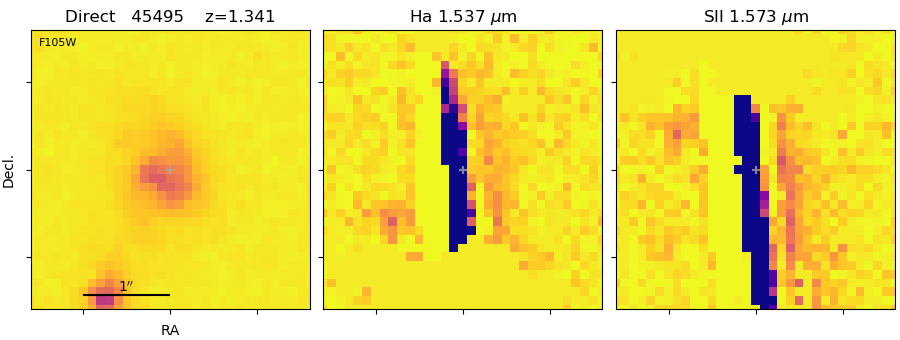

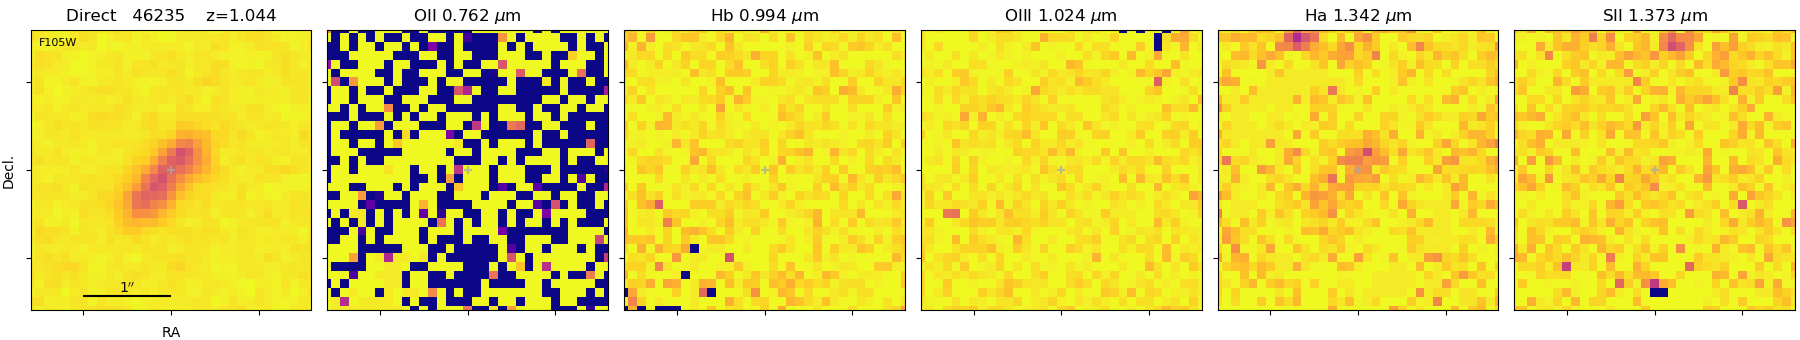

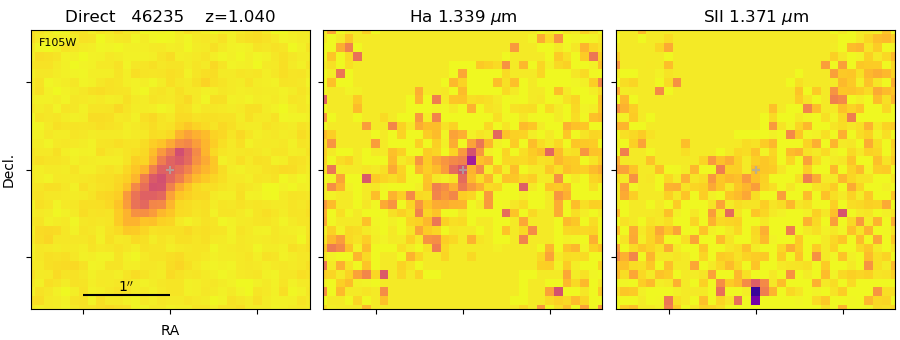

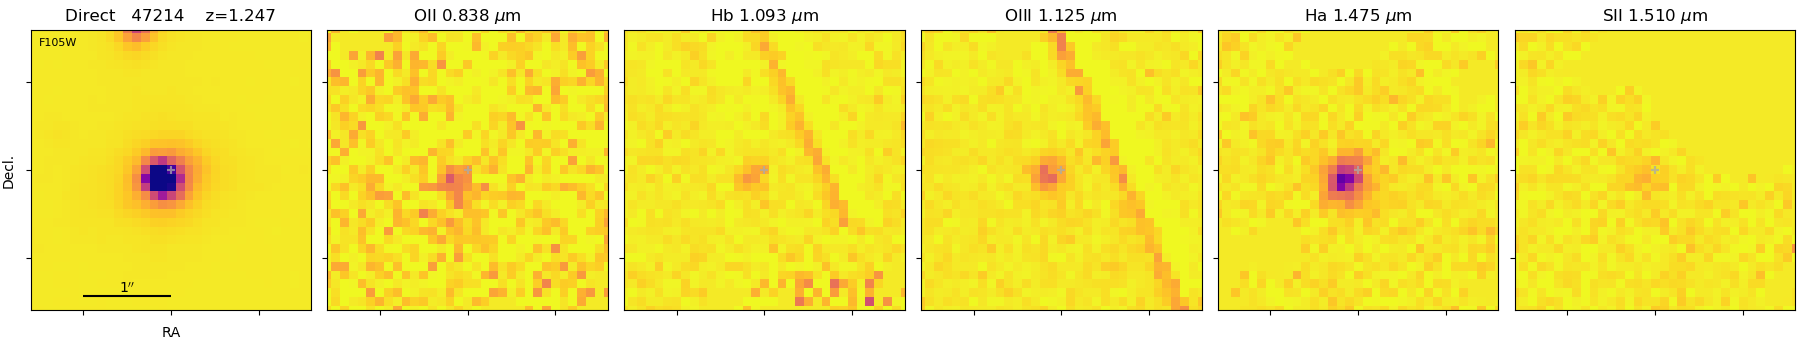

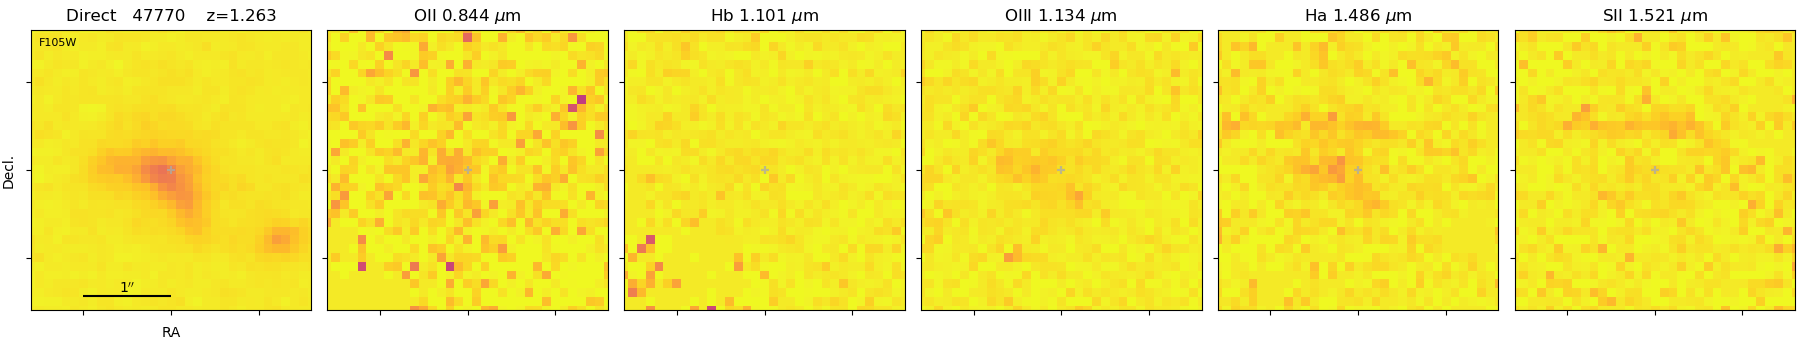

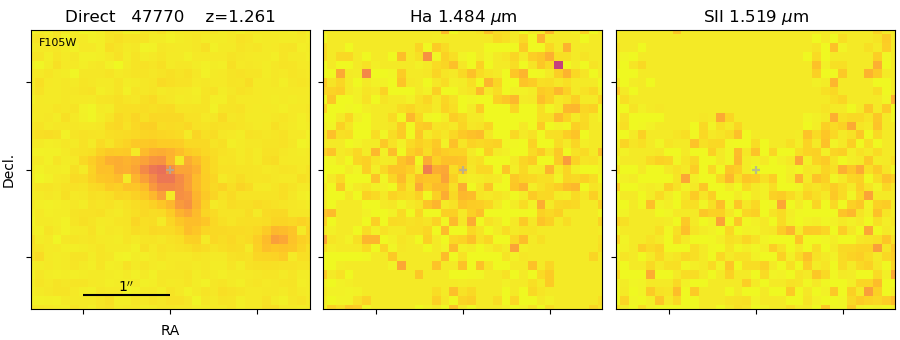

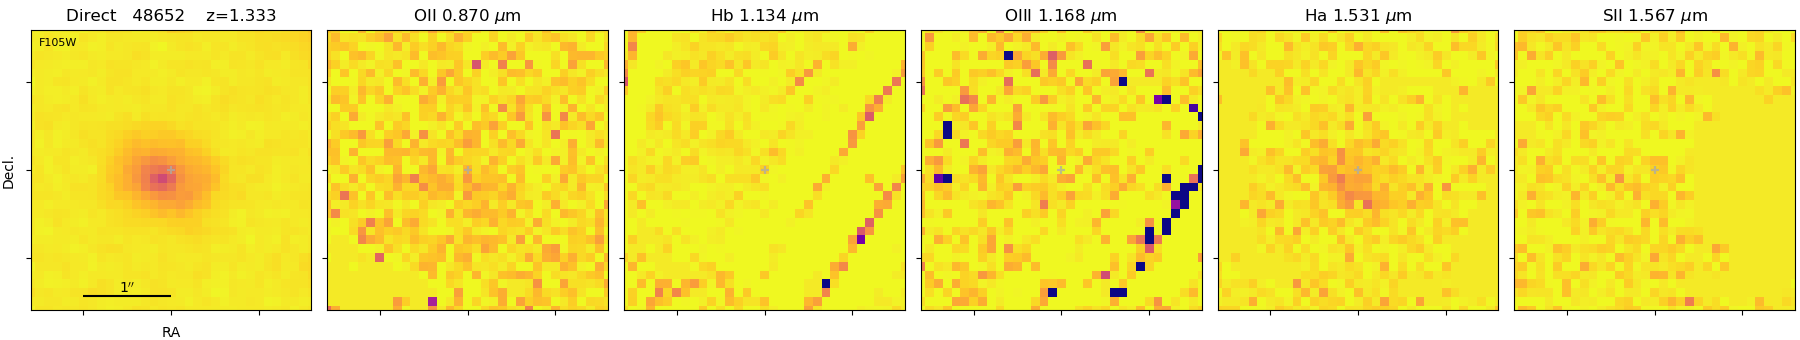

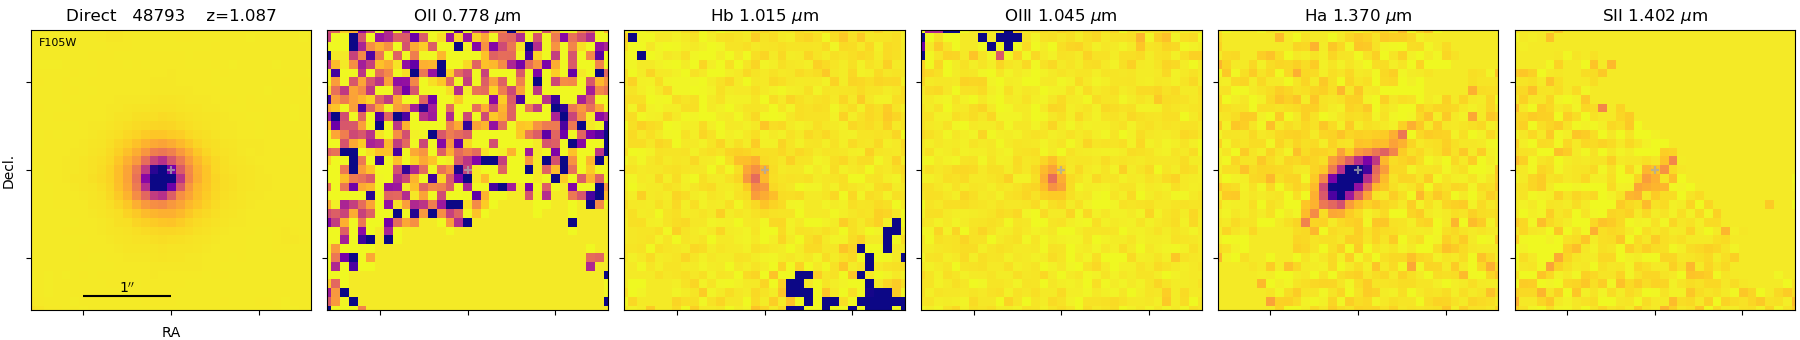

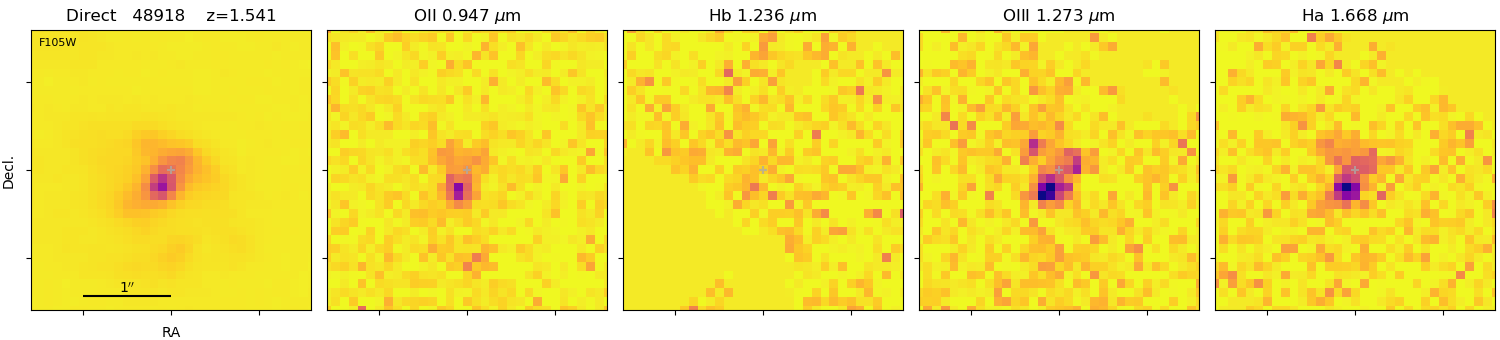

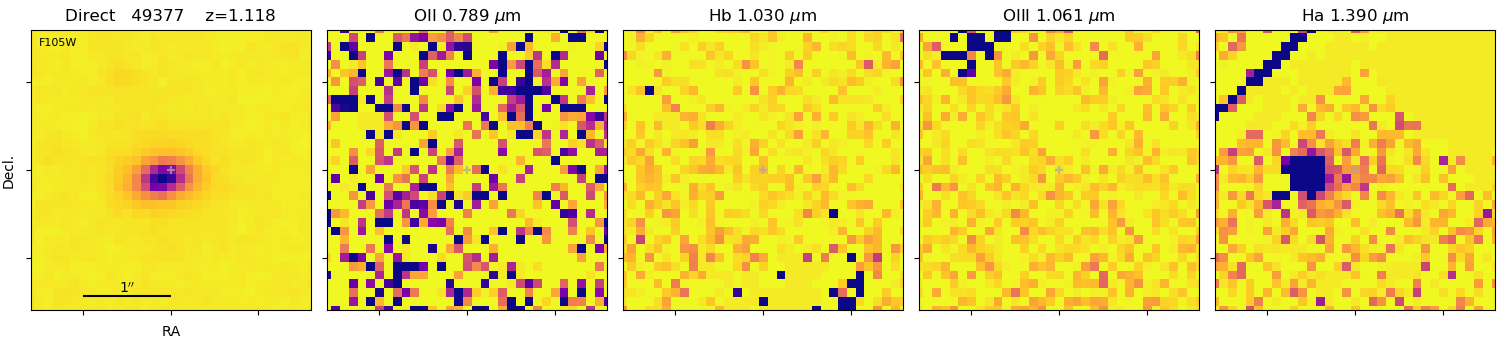

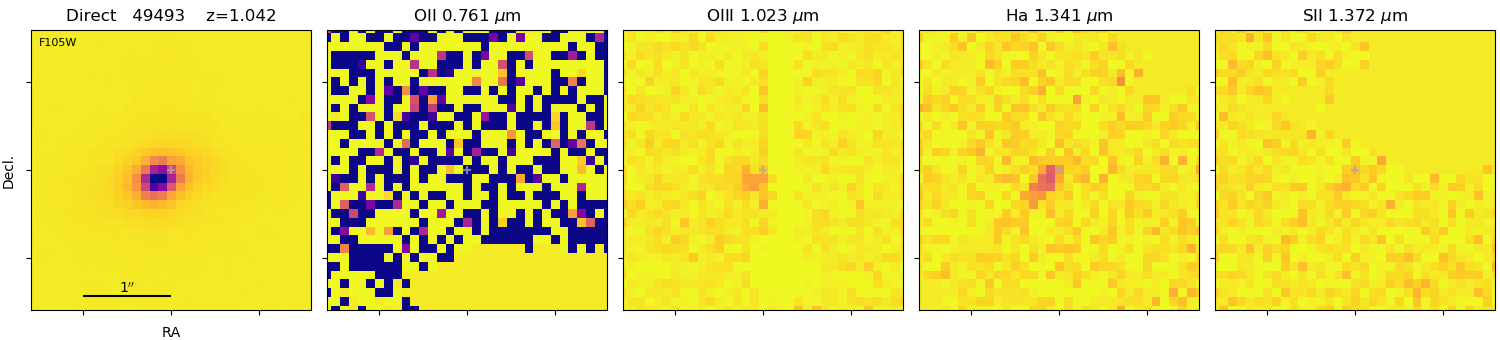

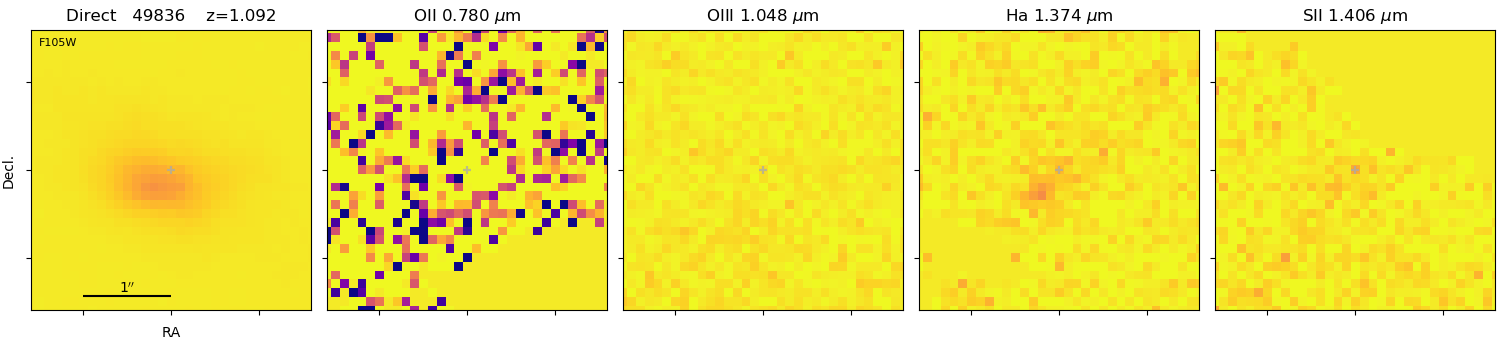

In [136]:
for i in range(len(SIDS)):
    if S_OII_f[i] > 0 and S_OIII_f[i] > 0 and S_Ha_f[i] > 0 and S_rshift84[i] - S_rshift16[i] < 0.005:
        flist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*{0}.line.png'.format(SIDS[i]))
        for ii in flist:
            display(Image(filename=ii))

In [147]:
glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*18197.line.png')

['/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GN2/j123652p6215/Prep/GN2_18197.line.png']

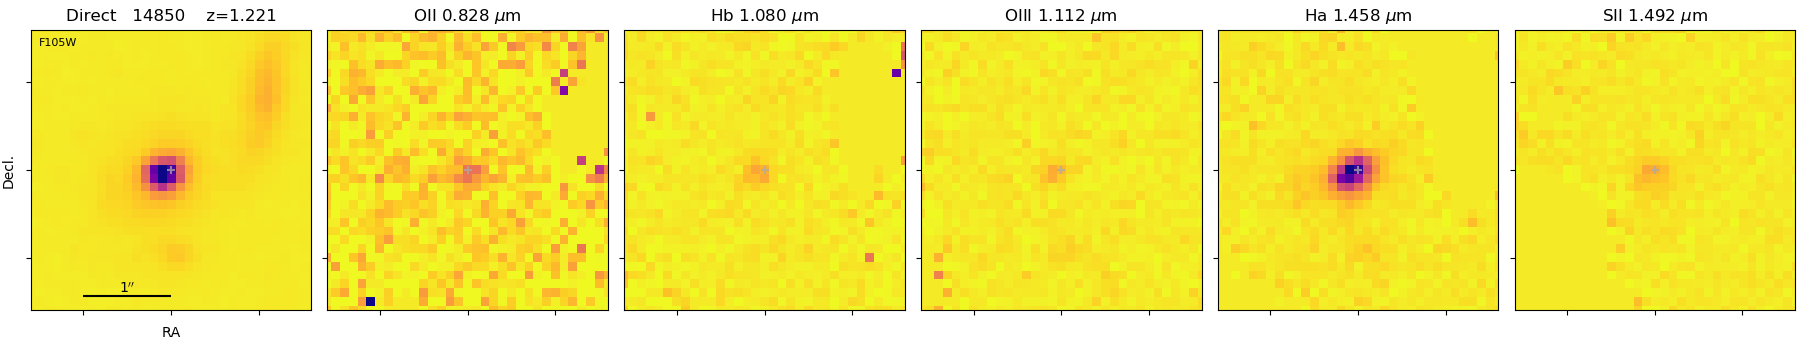

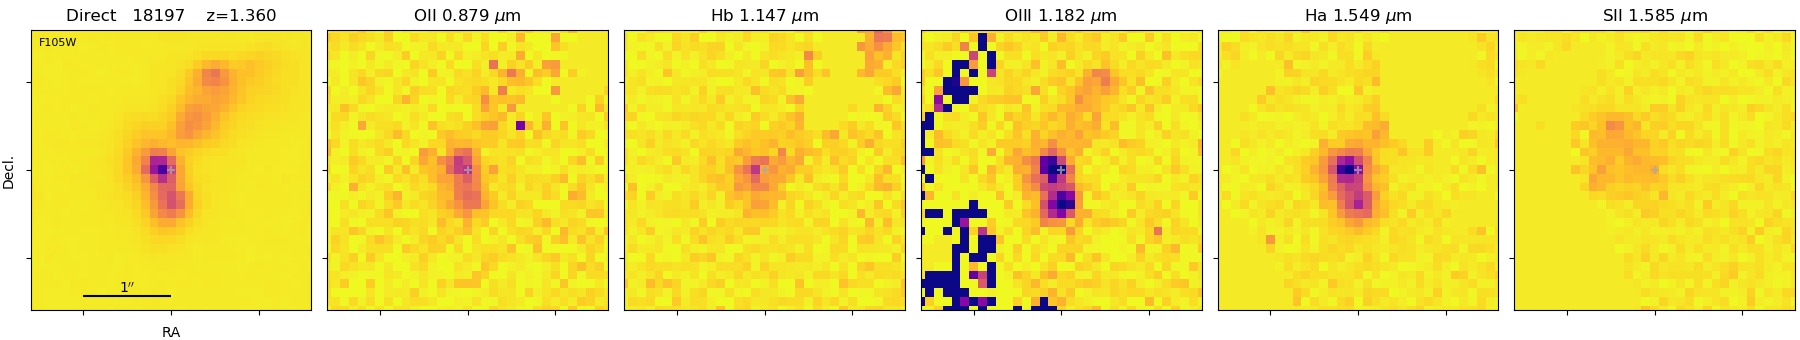

In [138]:
display(Image(filename=glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*14850.line.png')[0]))
display(Image(filename=glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*18197.line.png')[0]))

In [140]:
img=mpimg.imread(glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*18197.line.png')[0])

In [81]:
# rfwv = np.arange(400,10000,12)
# rfwv = np.arange(3600,3850,6)
# rfwv = np.arange(4700,5200,6)
rfwv = np.arange(6300,6860,6)

flxgrid = np.zeros([len(NIDS) + len(SIDS),len(rfwv)])
errgrid = np.zeros([len(NIDS) + len(SIDS),len(rfwv)])

# IDX = [U for U in range(len(rfwv)) if 4000 < rfwv[U] < 6000]

for i in range(len(NIDS) + len(SIDS)):
    if i < len(NIDS):
        field = 'N'
        u=i
        galaxy = NIDS[u]
        z = N_rshift[u]
        dz = N_rshift84[u] - N_rshift16[u]
        

    else:
        field = 'S'
        u = i - len(NIDS)
        galaxy = SIDS[u]
        z = S_rshift[u]
        dz = S_rshift84[u] - S_rshift16[u]
        
    if dz < 0.01:
    
        Bwv, Bfl, Ber = np.zeros([3,2])

        Rwv, Rfl, Rer = np.zeros([3,2])

        file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*{0}*/*/Prep/*{1}.1D.fits'.format(field,galaxy))[0]
        dat = fits.open(file)

        try:
            Bwv = np.array(dat['G102'].data['wave']).T
            Bfl = np.array(dat['G102'].data['flux'] / dat['G102'].data['flat']).T
            Ber = np.array(dat['G102'].data['err'] / dat['G102'].data['flat']).T


            Bwv = Bwv[Bfl**2 > 0]
            Ber = Ber[Bfl**2 > 0]
            Bfl = Bfl[Bfl**2 > 0]

        except:
            print('no g102')

        try:
            Rwv = np.array(dat['G141'].data['wave']).T
            Rfl = np.array(dat['G141'].data['flux'] / dat['G141'].data['flat']).T
            Rer = np.array(dat['G141'].data['err'] / dat['G141'].data['flat']).T

            Rwv = Rwv[Rfl**2 > 0]
            Rer = Rer[Rfl**2 > 0]
            Rfl = Rfl[Rfl**2 > 0]

        except:
            print('no g141')

        st,er = Stack_g102_g141(rfwv, Bwv, Bfl, Ber, Rwv, Rfl, Rer, z)

        er[st < 0] = 0
        st[st < 0] = 0
        
        er[st > 1.5E-17] = 0
        st[st > 1.5E-17] = 0   
#         er = er / np.trapz(st[IDX],rfwv[IDX])
#         st = st / np.trapz(st[IDX],rfwv[IDX])

        er = er / np.trapz(st,rfwv)
        st = st / np.trapz(st,rfwv)
        
        er[~(st**2 > 0)] =0 
        st[~(st**2 > 0)] =0

        errgrid[i] = er
        flxgrid[i] = st

no g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in power
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:

no g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


no g102
no g102
no g141
no g102
no g141
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g141
no g141
no g141
no g141
no g141
no g141
no g102
no g141
no g141
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g141


In [82]:
Ha_stack, Ha_error = Stack(rfwv,flxgrid,errgrid)
Ha_rfwv = rfwv

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


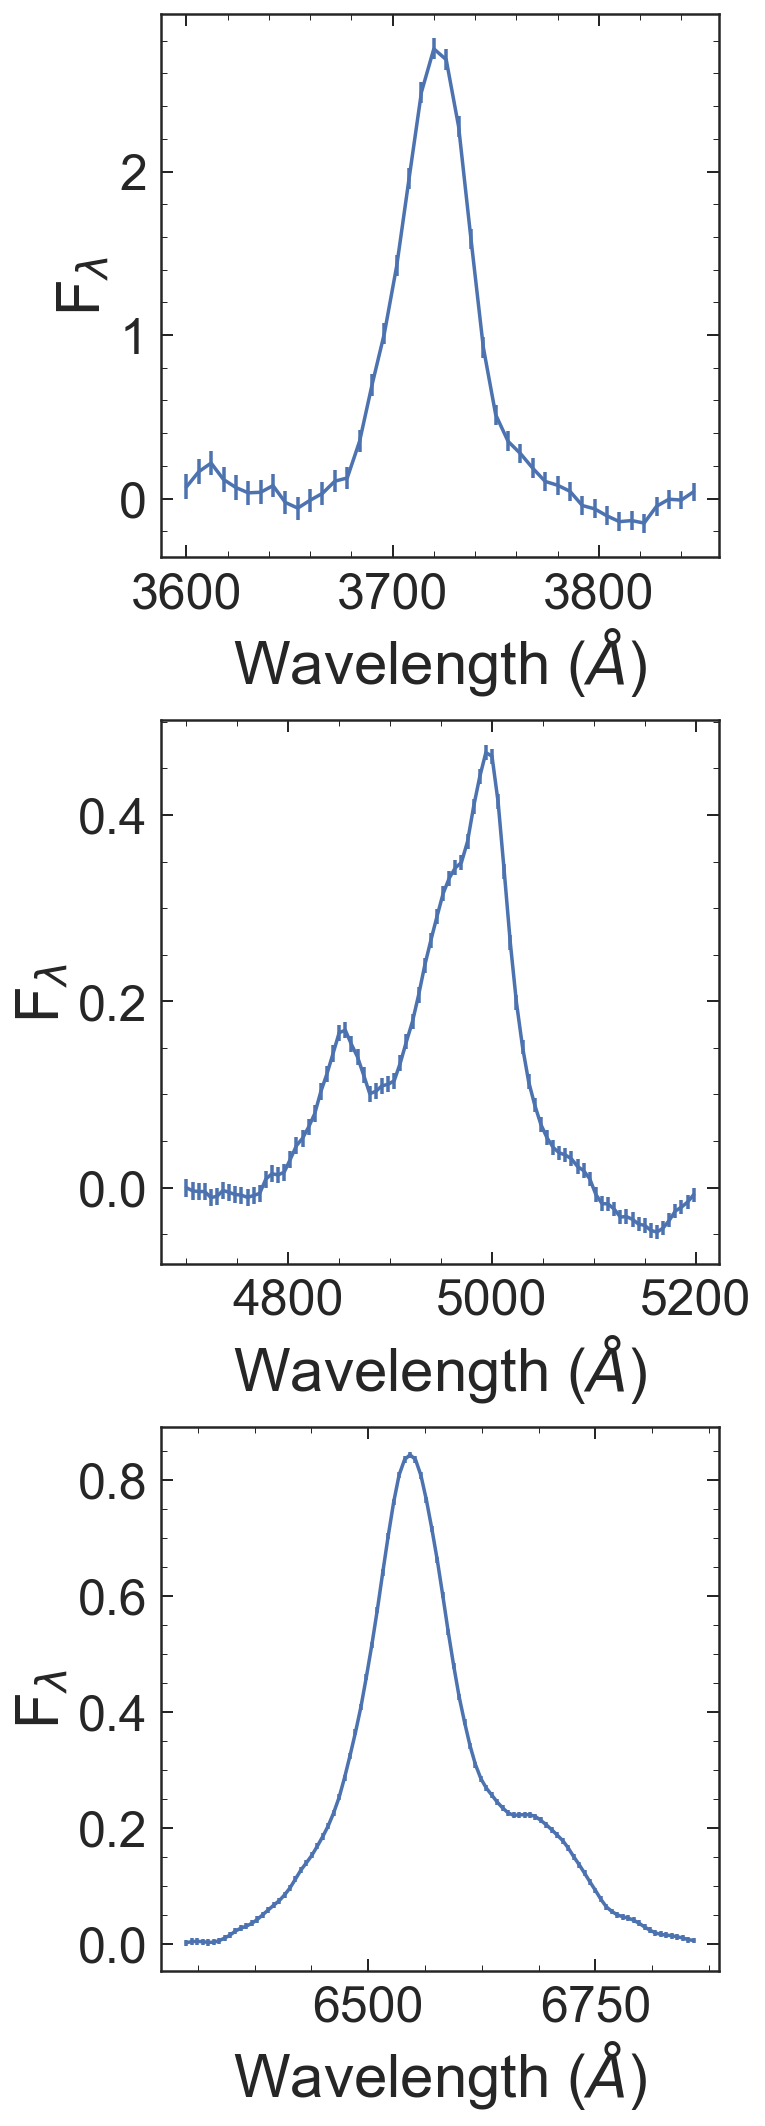

In [161]:
gs = gridspec.GridSpec(3,1, hspace = 0.3)
plt.figure(figsize=[5,18])

plt.subplot(gs[0])
plt.errorbar(OII_rfwv, (OII_stack - OIIline)*1000,OII_error*1000)
plt.xlabel('Wavelength ($\AA$)', fontsize=30)
plt.ylabel('F$_\lambda$', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(gs[1])
plt.errorbar(Hb_rfwv, (Hb_stack -  Hbline)*1000,Hb_error*1000)
plt.xlabel('Wavelength ($\AA$)', fontsize=30)
plt.ylabel('F$_\lambda$', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(gs[2])
plt.errorbar(Ha_rfwv, (Ha_stack - Haline)*1000,Ha_error*1000)
plt.xlabel('Wavelength ($\AA$)', fontsize=30)
plt.ylabel('F$_\lambda$', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.savefig('../plots/proposal_spec2.png' ,bbox_inches = 'tight')


In [108]:
Haline = interp1d([6300, 6900], [0.0016,0.0015])(Ha_rfwv)

<ErrorbarContainer object of 3 artists>

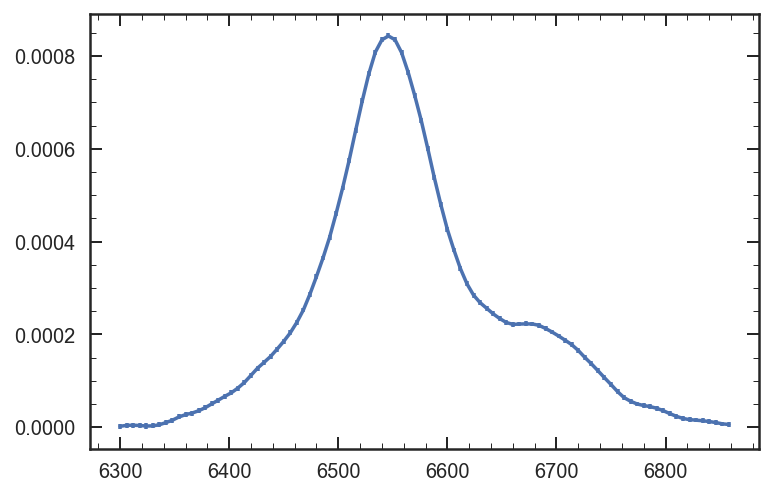

In [110]:
plt.errorbar(Ha_rfwv, Ha_stack - Haline,Ha_error)
# plt.plot(Ha_rfwv, Haline)

(0.75, 2)

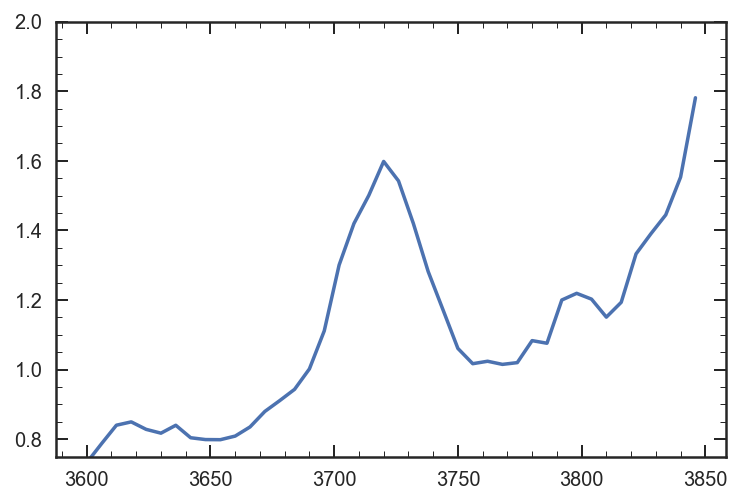

In [80]:
plt.plot(rfwv, np.sum(flxgrid, axis=0))
plt.ylim(0.75,2)

In [122]:
IDX = [ U for U in range(len(rfwv)) if rfwv[U] < 6400 or rfwv[U] > 6750]

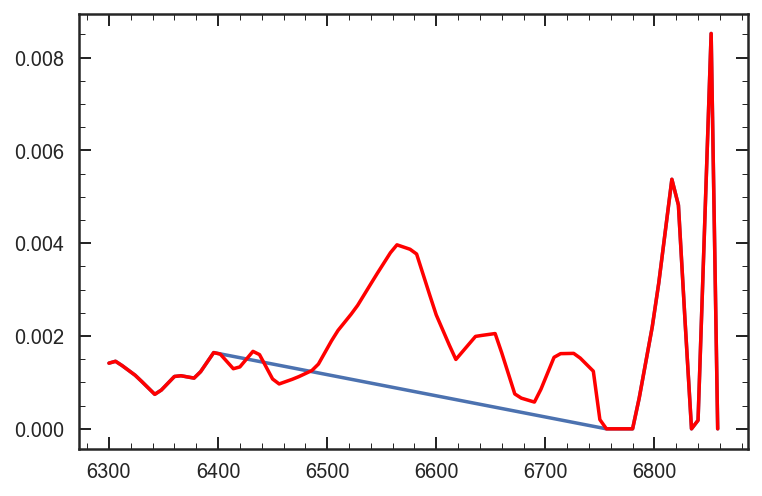

In [123]:
plt.plot(rfwv[IDX],flxgrid[2][IDX])
plt.plot(rfwv,flxgrid[2],'r')

In [164]:
file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*18197.1D.fits')[0]
dat = fits.open(file)

Bwv = np.array(dat['G102'].data['wave']).T
Bfl = np.array(dat['G102'].data['flux'] / dat['G102'].data['flat']).T
Ber = np.array(dat['G102'].data['err'] / dat['G102'].data['flat']).T


Bwv = Bwv[Bfl**2 > 0]
Ber = Ber[Bfl**2 > 0]
Bfl = Bfl[Bfl**2 > 0]

Rwv = np.array(dat['G141'].data['wave']).T
Rfl = np.array(dat['G141'].data['flux'] / dat['G141'].data['flat']).T
Rer = np.array(dat['G141'].data['err'] / dat['G141'].data['flat']).T

Rwv = Rwv[Rfl**2 > 0]
Rer = Rer[Rfl**2 > 0]
Rfl = Rfl[Rfl**2 > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14

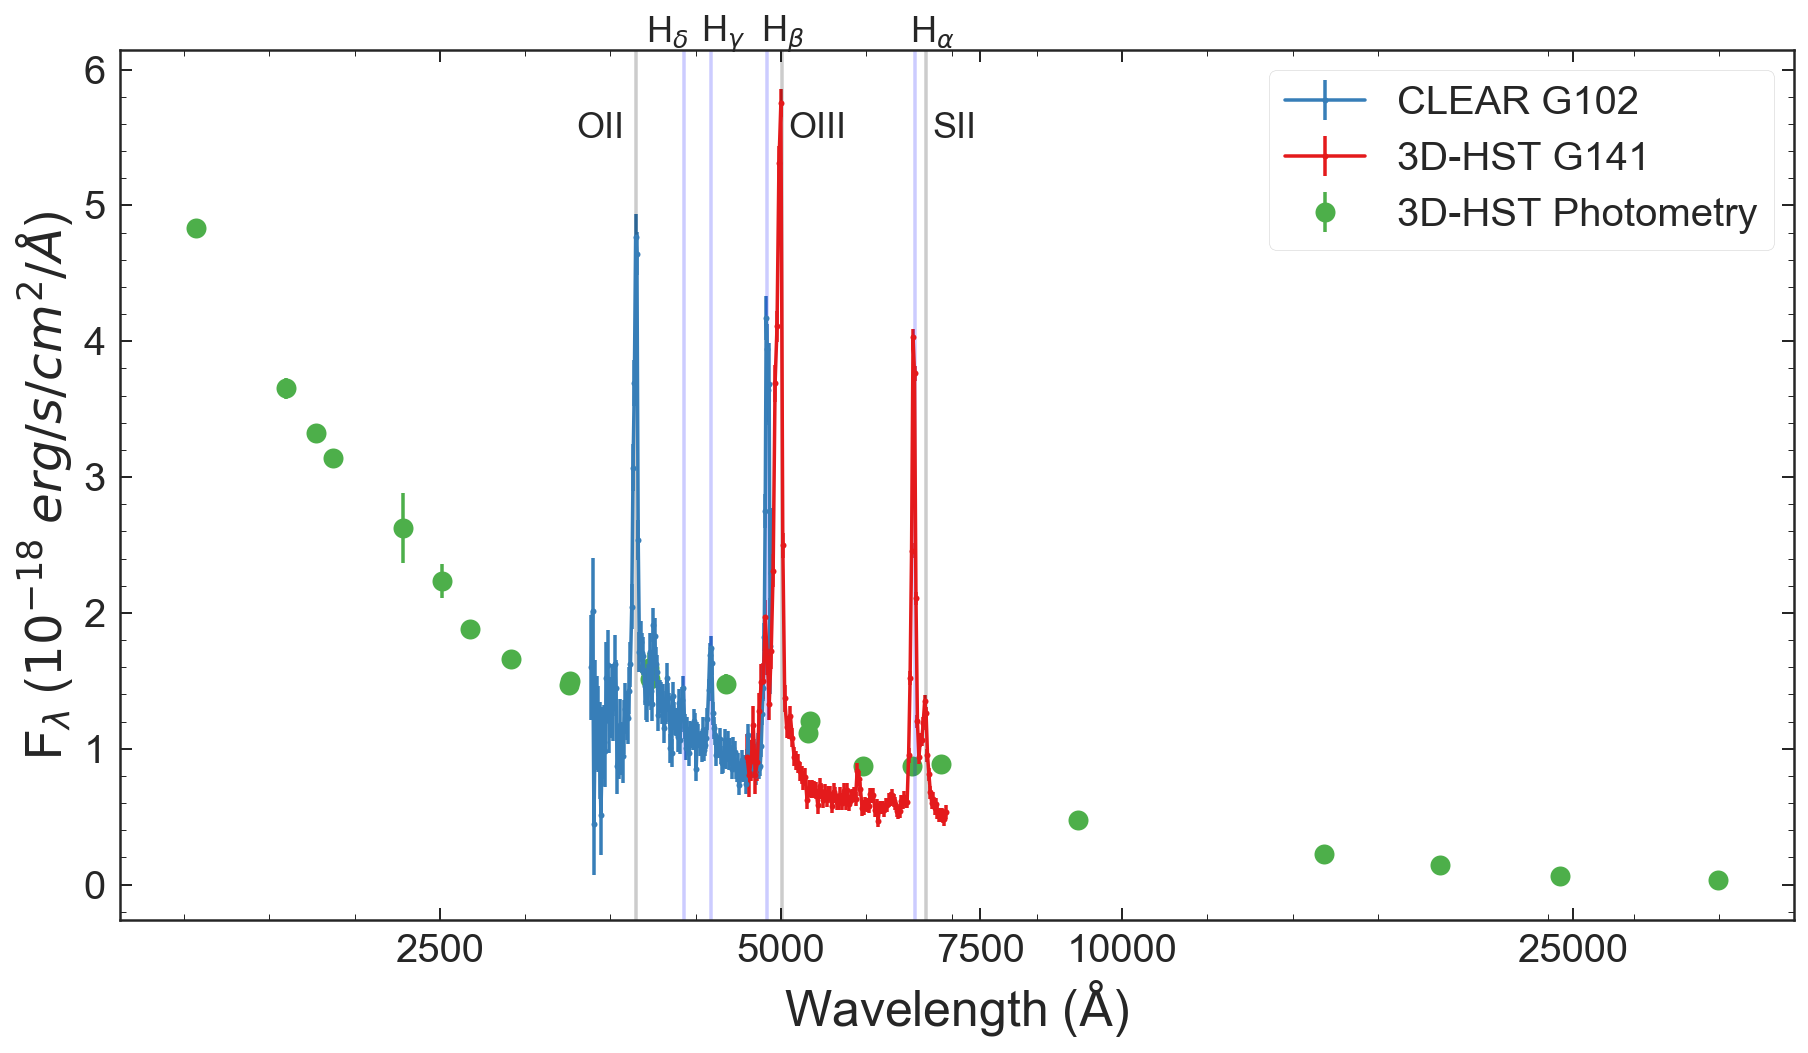

In [251]:
IDB = [U for U in range(len(Bwv)) if 8000 < Bwv[U] < 11575]
IDR = [U for U in range(len(Rwv)) if 11000 < Rwv[U] < 16500]

plt.figure(figsize=[15,8])

plt.errorbar(np.log10(Bwv[IDB] / 2.3596),Bfl[IDB] * 1E18,Ber[IDB]* 1E18,
           marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Rwv[IDR]/ 2.3596),Rfl[IDR]* 1E18,Rer[IDR]* 1E18,
        marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(pwv/ 2.3596),pfl*1E18,per*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
plt.xlabel('Wavelength ($ \\rm\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20, frameon=True,)
plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])


plt.axvline(np.log10(4102.89),linestyle='-', color='b', alpha=.2)
plt.axvline(np.log10(4341.68),linestyle='-', color='b', alpha=.2)
plt.axvline(np.log10(4862.68),linestyle='-', color='b', alpha=.2)
plt.axvline(np.log10(6564),linestyle='-', color='b', alpha=.2)
plt.axvline(np.log10(6718.29),linestyle='-', color='k', alpha=.2)

plt.axvline(np.log10(3727.092),linestyle='-', color='k',alpha=.2)
plt.axvline(np.log10(5008.240),linestyle='-', color='k',alpha=.2)

plt.text(np.log10(3300),5.5,'OII',fontsize=18)
plt.text(np.log10(3800),6.2,'H$_\delta$',fontsize=18)
plt.text(np.log10(4250),6.2,'H$_\gamma$',fontsize=18)
plt.text(np.log10(4800),6.2,'H$_\\beta$',fontsize=18)
plt.text(np.log10(5075),5.5,'OIII',fontsize=18)

plt.text(np.log10(6500),6.2,'H$_\\alpha$',fontsize=18)
plt.text(np.log10(6800),5.5,'SII',fontsize=18)
plt.savefig('../plots/proposal_spec3.png' ,bbox_inches = 'tight')

# plt.xlim(8000,16500)

In [250]:
pwv = np.array([15396.61615459,  3592.80961704,  4318.82810211,  4749.58321436,
         5920.81887956,  6816.84510106,  7692.30432928,  9032.68320402,
        12470.52032283, 12516.87830004, 13924.16391632, 16347.26631068,
        21577.26217183, 35569.29566469, 45020.33785231, 57450.28623538,
        79157.48615416,  4590.69361047,  5470.1203312 ,  6275.3615368 ,
         7671.08447906,  9028.09167916, 10543.5232349 ])

pfl = np.array([8.74965238e-19, 4.83559101e-18, 3.65349989e-18, 3.14100940e-18,
        2.23695630e-18, 1.65938483e-18, 1.50078504e-18, 1.51665891e-18,
        1.11339187e-18, 1.20177771e-18, 8.73848817e-19, 8.85340692e-19,
        4.77465577e-19, 2.21811858e-19, 1.45199504e-19, 6.42908417e-20,
        3.52198142e-20, 3.32786600e-18, 2.62401351e-18, 1.88317694e-18,
        1.47272346e-18, 1.59077552e-18, 1.47385727e-18])

per = np.array([2.08805756e-20, 5.84183098e-20, 7.56524749e-20, 2.63543966e-20,
        1.24944690e-19, 6.67747644e-20, 3.89741304e-20, 6.36038147e-20,
        1.41767541e-20, 8.85528733e-21, 6.15987763e-20, 6.14171454e-20,
        4.94135347e-21, 2.13594771e-21, 9.52439155e-22, 4.34221337e-21,
        2.40241428e-21, 2.50395005e-20, 2.58737192e-19, 4.41817186e-20,
        1.73418777e-20, 1.17070107e-19, 7.34788724e-20])